In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [3]:
# Does not work for the mxnet version on 3/30/2017
# model_dir_name = 'Sat16ClassFinetuned'
# model_name = 'Sat16ClassFinetuned'
# model_iteration = 10
# output_symbol_name = 'flatten_output'
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'saturation_mean_224.npy'))

# model_dir_name = 'vgg16-blue'
# model_name = 'vgg16-blue'
# model_iteration = 0
# output_symbol_name = 'fc7_output'
# output_dim = 4096
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'vgg_mean.npy'))

# model_dir_name = 'vgg19'
# model_name = 'vgg19'
# model_iteration = 0
# output_symbol_name = 'fc8_output'

# model_dir_name = 'inception-bn'
# model_name = 'Inception-BN'
# model_iteration = 126
# output_symbol_name = 'flatten_output'
# mean_img = mx.nd.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.nd'))['mean_img'].asnumpy()

model_dir_name = 'inception-bn-blue'
download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# Reference on how to predict with mxnet model:
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
flatten_output = model0.get_internals()[output_symbol_name]
model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# Increase batch_size to 500 does not save any time.
batch_size = 256
model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

# model_dir_name = 'inception-bn-sat'
# model_name = 'inception-bn-sat'
# model_iteration = 0
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), model_iteration, ctx=mx.gpu())

rm -rf /shared/mxnet_models/inception-bn-blue && mkdir -p /shared/mxnet_models
aws s3 cp --recursive s3://mousebrainatlas-data/mxnet_models/inception-bn-blue /shared/mxnet_models/inception-bn-blue


Child returned 0
Child returned 0
1.95 seconds.
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
# Visualize network topology

# a = mx.viz.plot_network(flatten_output, shape={"data":(1, 1, 224, 224)}, node_attrs={"shape":'rect',"fixedsize":'false'})
# a.render(model_name)

In [4]:
patch_size = 224
half_size = patch_size/2
stride = 56

In [ ]:
# def convert_to_saturation(img, rescale=True):
#     """
#     Generate saturation channel as a grayscale image.
#     """
#     ma = img.max(axis=-1)
#     mi = img.min(axis=-1)
# #     sys.stderr.write('compute min and max color components: %.2f seconds\n' % (time.time() - t1)) # ~5s

# #     t1 = time.time()
#     s = np.nan_to_num(mi/ma.astype(np.float))
# #     sys.stderr.write('min oiver max: %.2f seconds\n' % (time.time() - t1)) # ~2s

# #     t1 = time.time()
#     if rescale:
#         pmax = s.max()
#         pmin = s.min()
#         s = (s - pmin) / (pmax - pmin)
# #     sys.stderr.write('rescale: %.2f seconds\n' % (time.time() - t1)) # ~3s

#     return img_as_ubyte(s)

In [7]:
for stack in ['MD635']:
    download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True, redownload=True)

rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_masks_cropped && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_masks_cropped /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_masks_cropped


Child returned 0
Child returned 0
3.53 seconds.


In [8]:
for stack in ['MD635']:
    # 450 second to download entire folder one stack
    # 1025 seconds to download file by file
    download_from_s3(DataManager.get_image_dir(stack=stack, version='cropped_gray'), is_dir=True, redownload=True)

rm -rf /shared/CSHL_data_processed/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray /shared/CSHL_data_processed/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray


Child returned 0
Child returned 0
682.09 seconds.


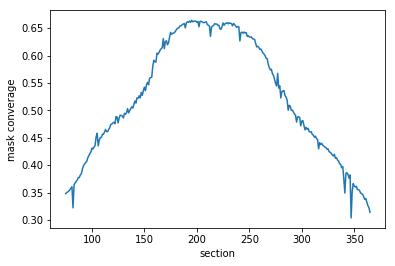

In [9]:
# This shows that a mask covers 50% to 75% of the full area, so predicting only on masks roughly halves the time.

stack = 'MD635'
image_width, image_height = metadata_cache['image_shape'][stack]
first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]
a = image_width / 32 * image_height / 32
mask_coverage = {sec: np.count_nonzero(DataManager.load_thumbnail_mask_v3(stack=stack, section=sec))/float(a)
for sec in range(first_detect_sec, last_detect_sec+1) if not is_invalid(stack=stack, sec=sec)}
plt.plot(mask_coverage.keys(), mask_coverage.values());
plt.xlabel('section');
plt.ylabel('mask converage');

In [26]:
input_img_version = 'cropped_gray_linearNormalized'

In [ ]:
# for stack in all_stacks:
for stack in ['MD635']:
    
    download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
    download_from_s3(DataManager.get_image_dir(stack=stack, version=input_img_version), is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

    first_sec, last_sec = metadata_cache['section_limits'][stack]

    bar = show_progress_bar(first_sec, last_sec)
 
    for sec in range(first_sec, last_sec+1):
#     for sec in range(153, 154):
        if is_invalid(stack=stack, sec=sec):
            continue  
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                
        bar.value = sec
        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, version='aligned_cropped')
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        sample_locations_roi = sample_locations[indices_roi]
        
        t = time.time()
        im = DataManager.load_image(stack=stack, section=sec, version=input_img_version, resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        t = time.time()

        patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224
        patches_mean_subtracted = patches - mean_img
        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
#         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

        # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
        # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

        t1 = time.time()        
        data_iter = mx.io.NDArrayIter(
                        patches_mean_subtracted_input, 
                        batch_size=batch_size,
                        shuffle=False)
        outputs = model.predict(data_iter, always_output_list=True)
        features = outputs[0].asnumpy()
        
#         data_iter.reset()
        del data_iter
        
#         n_each_iter = 80000
#         for b in range(0, n, n_each_iter):
#             data_iter = mx.io.NDArrayIter(
#                             patches_mean_subtracted_input[b:b+n_each_iter], 
#                             batch_size=batch_size,
#                             shuffle=False)
            
#             # Reference on how to predict with mxnet model:
#             # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
# #             model.bind(data_iter.provide_data, for_training=False)
# #             model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
#             outputs = model.predict(data_iter, always_output_list=True)
#             features[b:b+n_each_iter] = outputs[0].asnumpy()
        
#             del data_iter
        
        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
        # All times below are after the first iteration (which is slow due to model loading into GPU).
        # inception-bn-blue ~125s / 48k patches on workstation single Titan X
        # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

    # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718
        
#         del patches_mean_subtracted_input, patches, im
        del patches_mean_subtracted_input, patches_mean_subtracted, patches, im
        
        t = time.time()

        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, section=sec,
                                                           version=input_img_version)
        create_parent_dir_if_not_exists(features_fp)
        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)
        
        del features

        feature_locs_fp = DataManager.get_dnn_feature_locations_filepath(stack=stack, model_name=model_name, 
                                                                         section=sec,
                                                                        version=input_img_version)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s
        
# Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80."

MD635


Widget Javascript not detected.  It may not be installed or enabled properly.



Section 75.
locate patches: 0.02 seconds
32840 samples.
load image: 0.24 seconds
extract patches: 3.17 seconds
predict: 18.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F25-2016.05.18-21.02.30_MD635_3_0075_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F25-2016.05.18-21.02.30_MD635_3_0075_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F25-2016.05.18-21.02.30_MD635_3_0075_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F25-2016.05.18-21.02.30_MD635_3_0075_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.31 seconds

Section 76.
locate patches: 0.02 seconds
33037 samples.
load image: 0.24 seconds
extract patches: 3.20 seconds
predict: 18.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_1_0076_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_1_0076_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_1_0076_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_1_0076_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.36 seconds

Section 77.
locate patches: 0.02 seconds
33112 samples.
load image: 0.24 seconds
extract patches: 3.23 seconds
predict: 18.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_2_0077_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_2_0077_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_2_0077_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_2_0077_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.32 seconds

Section 78.
locate patches: 0.02 seconds
33286 samples.
load image: 0.24 seconds
extract patches: 3.22 seconds
predict: 18.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_3_0078_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_3_0078_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_3_0078_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F26-2016.05.18-21.16.59_MD635_3_0078_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.42 seconds

Section 79.
locate patches: 0.02 seconds
33498 samples.
load image: 0.24 seconds
extract patches: 3.24 seconds
predict: 18.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_1_0079_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_1_0079_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_1_0079_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_1_0079_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.37 seconds

Section 80.
locate patches: 0.02 seconds
33754 samples.
load image: 0.24 seconds
extract patches: 3.27 seconds
predict: 18.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_2_0080_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_2_0080_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_2_0080_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_2_0080_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.33 seconds

Section 81.
locate patches: 0.02 seconds
34014 samples.
load image: 0.24 seconds
extract patches: 3.32 seconds
predict: 19.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_3_0081_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_3_0081_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_3_0081_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F27-2016.05.18-21.31.38_MD635_3_0081_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.32 seconds

Section 82.
locate patches: 0.02 seconds
30398 samples.
load image: 0.25 seconds
extract patches: 2.99 seconds
predict: 17.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_1_0082_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_1_0082_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_1_0082_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_1_0082_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.19 seconds

Section 83.
locate patches: 0.02 seconds
34363 samples.
load image: 0.24 seconds
extract patches: 3.34 seconds
predict: 19.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_2_0083_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_2_0083_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_2_0083_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_2_0083_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.59 seconds

Section 84.
locate patches: 0.02 seconds
34706 samples.
load image: 0.25 seconds
extract patches: 3.36 seconds
predict: 19.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_3_0084_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_3_0084_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_3_0084_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F28-2016.05.18-21.46.26_MD635_3_0084_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.80 seconds

Section 85.
locate patches: 0.02 seconds
34898 samples.
load image: 0.24 seconds
extract patches: 3.37 seconds
predict: 19.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_1_0085_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_1_0085_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_1_0085_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_1_0085_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.57 seconds

Section 86.
locate patches: 0.02 seconds
35157 samples.
load image: 0.24 seconds
extract patches: 3.39 seconds
predict: 19.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_2_0086_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_2_0086_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_2_0086_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_2_0086_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.38 seconds

Section 87.
locate patches: 0.02 seconds
35608 samples.
load image: 0.24 seconds
extract patches: 3.45 seconds
predict: 19.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_3_0087_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_3_0087_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_3_0087_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F29-2016.05.18-22.01.14_MD635_3_0087_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.92 seconds

Section 88.
locate patches: 0.02 seconds
35606 samples.
load image: 0.24 seconds
extract patches: 3.45 seconds
predict: 20.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_1_0088_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_1_0088_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_1_0088_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_1_0088_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.28 seconds

Section 89.
locate patches: 0.02 seconds
36071 samples.
load image: 0.24 seconds
extract patches: 3.48 seconds
predict: 20.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_2_0089_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_2_0089_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_2_0089_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_2_0089_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.67 seconds

Section 90.
locate patches: 0.02 seconds
36291 samples.
load image: 0.24 seconds
extract patches: 3.53 seconds
predict: 20.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_3_0090_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_3_0090_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_3_0090_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F30-2016.05.18-22.15.39_MD635_3_0090_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.67 seconds

Section 91.
locate patches: 0.02 seconds
37095 samples.
load image: 0.25 seconds
extract patches: 3.63 seconds
predict: 20.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_1_0091_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_1_0091_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_1_0091_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_1_0091_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.58 seconds

Section 92.
locate patches: 0.02 seconds
37650 samples.
load image: 0.24 seconds
extract patches: 3.65 seconds
predict: 21.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_2_0092_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_2_0092_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_2_0092_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F31-2016.05.18-22.31.18_MD635_2_0092_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.55 seconds

Section 94.
locate patches: 0.02 seconds
38209 samples.
load image: 0.24 seconds
extract patches: 3.71 seconds
predict: 21.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_1_0094_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_1_0094_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
3.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_1_0094_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_1_0094_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.87 seconds

Section 95.
locate patches: 0.02 seconds
38359 samples.
load image: 0.24 seconds
extract patches: 3.74 seconds
predict: 21.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_2_0095_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_2_0095_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_2_0095_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_2_0095_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.61 seconds

Section 96.
locate patches: 0.02 seconds
38972 samples.
load image: 0.24 seconds
extract patches: 3.77 seconds
predict: 21.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_3_0096_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_3_0096_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_3_0096_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F32-2016.05.18-22.50.16_MD635_3_0096_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.57 seconds

Section 97.
locate patches: 0.02 seconds
39343 samples.
load image: 0.24 seconds
extract patches: 3.83 seconds
predict: 24.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_1_0097_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_1_0097_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_1_0097_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_1_0097_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.64 seconds

Section 98.
locate patches: 0.02 seconds
39747 samples.
load image: 0.24 seconds
extract patches: 3.85 seconds
predict: 30.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_2_0098_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_2_0098_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_2_0098_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_2_0098_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.90 seconds

Section 99.
locate patches: 0.02 seconds
40009 samples.
load image: 0.25 seconds
extract patches: 3.88 seconds
predict: 34.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_3_0099_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_3_0099_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_3_0099_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F33-2016.05.18-23.06.34_MD635_3_0099_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.71 seconds

Section 100.
locate patches: 0.02 seconds
40699 samples.
load image: 0.24 seconds
extract patches: 3.97 seconds
predict: 46.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_1_0100_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_1_0100_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
3.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_1_0100_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_1_0100_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.93 seconds

Section 101.
locate patches: 0.02 seconds
40549 samples.
load image: 0.24 seconds
extract patches: 3.93 seconds
predict: 45.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_2_0101_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_2_0101_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_2_0101_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_2_0101_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.56 seconds

Section 102.
locate patches: 0.02 seconds
40859 samples.
load image: 0.24 seconds
extract patches: 3.95 seconds
predict: 48.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_3_0102_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_3_0102_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_3_0102_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F34-2016.05.18-23.23.55_MD635_3_0102_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.91 seconds

Section 103.
locate patches: 0.02 seconds
41143 samples.
load image: 0.24 seconds
extract patches: 3.98 seconds
predict: 53.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_1_0103_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_1_0103_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
3.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_1_0103_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_1_0103_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.74 seconds

Section 104.
locate patches: 0.02 seconds
42622 samples.
load image: 0.25 seconds
extract patches: 4.14 seconds
predict: 77.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_2_0104_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_2_0104_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_2_0104_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_2_0104_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.64 seconds

Section 105.
locate patches: 0.02 seconds
43273 samples.
load image: 0.24 seconds
extract patches: 4.19 seconds
predict: 88.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_3_0105_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_3_0105_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_3_0105_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F35-2016.05.18-23.40.52_MD635_3_0105_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.07 seconds

Section 106.
locate patches: 0.02 seconds
41111 samples.
load image: 0.24 seconds
extract patches: 3.97 seconds
predict: 54.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_1_0106_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_1_0106_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_1_0106_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_1_0106_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.91 seconds

Section 107.
locate patches: 0.02 seconds
42102 samples.
load image: 0.24 seconds
extract patches: 4.06 seconds
predict: 69.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_2_0107_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_2_0107_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_2_0107_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_2_0107_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.99 seconds

Section 108.
locate patches: 0.02 seconds
42543 samples.
load image: 0.24 seconds
extract patches: 4.12 seconds
predict: 76.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_3_0108_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_3_0108_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_3_0108_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F36-2016.05.18-23.59.35_MD635_3_0108_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.68 seconds

Section 109.
locate patches: 0.02 seconds
42577 samples.
load image: 0.24 seconds
extract patches: 4.15 seconds
predict: 77.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_1_0109_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_1_0109_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_1_0109_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_1_0109_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.54 seconds

Section 110.
locate patches: 0.02 seconds
43108 samples.
load image: 0.24 seconds
extract patches: 4.19 seconds
predict: 85.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_2_0110_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_2_0110_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_2_0110_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_2_0110_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.40 seconds

Section 111.
locate patches: 0.02 seconds
43122 samples.
load image: 0.24 seconds
extract patches: 4.19 seconds
predict: 86.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_3_0111_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_3_0111_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_3_0111_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F37-2016.05.23-14.05.18_MD635_3_0111_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.36 seconds

Section 113.
locate patches: 0.02 seconds
43930 samples.
load image: 0.25 seconds
extract patches: 4.25 seconds
predict: 98.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_2_0113_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_2_0113_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_2_0113_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_2_0113_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.94 seconds

Section 114.
locate patches: 0.02 seconds
43551 samples.
load image: 0.24 seconds
extract patches: 4.21 seconds
predict: 92.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_3_0114_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_3_0114_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_3_0114_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F38-2016.05.19-00.34.28_MD635_3_0114_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.05 seconds

Section 115.
locate patches: 0.02 seconds
43557 samples.
load image: 0.24 seconds
extract patches: 4.22 seconds
predict: 94.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_1_0115_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_1_0115_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_1_0115_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_1_0115_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.59 seconds

Section 116.
locate patches: 0.02 seconds
43958 samples.
load image: 0.24 seconds
extract patches: 4.25 seconds
predict: 100.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_2_0116_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_2_0116_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_2_0116_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_2_0116_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.24 seconds

Section 117.
locate patches: 0.02 seconds
44238 samples.
load image: 0.24 seconds
extract patches: 4.29 seconds
predict: 104.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_3_0117_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_3_0117_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_3_0117_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F39-2016.05.19-00.52.10_MD635_3_0117_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.89 seconds

Section 118.
locate patches: 0.02 seconds
44807 samples.
load image: 0.24 seconds
extract patches: 4.34 seconds
predict: 113.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_1_0118_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_1_0118_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_1_0118_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_1_0118_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.66 seconds

Section 119.
locate patches: 0.02 seconds
44897 samples.
load image: 0.24 seconds
extract patches: 4.34 seconds
predict: 113.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_2_0119_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_2_0119_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
7.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_2_0119_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_2_0119_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 9.53 seconds

Section 120.
locate patches: 0.02 seconds
45098 samples.
load image: 0.24 seconds
extract patches: 4.36 seconds
predict: 119.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_3_0120_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_3_0120_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_3_0120_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F40-2016.05.19-01.08.51_MD635_3_0120_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.16 seconds

Section 121.
locate patches: 0.02 seconds
45202 samples.
load image: 0.24 seconds
extract patches: 4.38 seconds
predict: 118.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_1_0121_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_1_0121_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_1_0121_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_1_0121_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.24 seconds

Section 122.
locate patches: 0.02 seconds
44967 samples.
load image: 0.24 seconds
extract patches: 4.34 seconds
predict: 114.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_2_0122_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_2_0122_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
3.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_2_0122_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_2_0122_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.85 seconds

Section 123.
locate patches: 0.02 seconds
46196 samples.
load image: 0.24 seconds
extract patches: 4.47 seconds
predict: 132.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_3_0123_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_3_0123_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_3_0123_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F41-2016.05.19-01.28.39_MD635_3_0123_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
1.05 seconds.
save: 4.10 seconds

Section 124.
locate patches: 0.02 seconds
46048 samples.
load image: 0.24 seconds
extract patches: 4.44 seconds
predict: 128.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_1_0124_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_1_0124_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_1_0124_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_1_0124_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.93 seconds

Section 125.
locate patches: 0.02 seconds
45059 samples.
load image: 0.24 seconds
extract patches: 4.37 seconds
predict: 112.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_2_0125_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_2_0125_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_2_0125_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_2_0125_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.11 seconds

Section 126.
locate patches: 0.02 seconds
45991 samples.
load image: 0.24 seconds
extract patches: 4.45 seconds
predict: 128.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_3_0126_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_3_0126_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_3_0126_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F42-2016.05.19-01.47.04_MD635_3_0126_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.62 seconds

Section 127.
locate patches: 0.02 seconds
46437 samples.
load image: 0.24 seconds
extract patches: 4.50 seconds
predict: 177.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_2_0143_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_2_0143_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_2_0143_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_2_0143_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.00 seconds

Section 144.
locate patches: 0.02 seconds
49341 samples.
load image: 0.24 seconds
extract patches: 4.77 seconds
predict: 178.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_3_0144_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_3_0144_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_3_0144_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F48-2016.05.19-03.40.12_MD635_3_0144_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.69 seconds

Section 145.
locate patches: 0.02 seconds
49761 samples.
load image: 0.24 seconds
extract patches: 4.82 seconds
predict: 184.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_1_0145_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_1_0145_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_1_0145_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_1_0145_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.34 seconds

Section 146.
locate patches: 0.02 seconds
49411 samples.
load image: 0.24 seconds
extract patches: 4.77 seconds
predict: 175.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_2_0146_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_2_0146_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_2_0146_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.19-03.59.43_MD635_2_0146_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.79 seconds

Section 147.
locate patches: 0.02 seconds
50343 samples.
load image: 0.24 seconds
extract patches: 4.85 seconds
predict: 191.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.23-14.25.13_MD635_3_0147_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.23-14.25.13_MD635_3_0147_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.23-14.25.13_MD635_3_0147_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F49-2016.05.23-14.25.13_MD635_3_0147_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.02 seconds

Section 148.
locate patches: 0.02 seconds
49847 samples.
load image: 0.24 seconds
extract patches: 4.82 seconds
predict: 180.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_1_0148_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_1_0148_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_1_0148_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_1_0148_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.31 seconds

Section 149.
locate patches: 0.02 seconds
50634 samples.
load image: 0.24 seconds
extract patches: 4.92 seconds
predict: 195.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_2_0149_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_2_0149_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_2_0149_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_2_0149_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.11 seconds

Section 150.
locate patches: 0.02 seconds
51257 samples.
load image: 0.24 seconds
extract patches: 4.96 seconds
predict: 202.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_3_0150_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_3_0150_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
3.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_3_0150_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F50-2016.05.23-14.45.07_MD635_3_0150_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 5.62 seconds

Section 151.
locate patches: 0.02 seconds
50666 samples.
load image: 0.24 seconds
extract patches: 4.91 seconds
predict: 190.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_1_0151_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_1_0151_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_1_0151_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_1_0151_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.29 seconds

Section 152.
locate patches: 0.02 seconds
51668 samples.
load image: 0.24 seconds
extract patches: 5.01 seconds
predict: 206.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_2_0152_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_2_0152_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_2_0152_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_2_0152_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.29 seconds

Section 153.
locate patches: 0.02 seconds
52100 samples.
load image: 0.24 seconds
extract patches: 5.07 seconds
predict: 210.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_3_0153_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_3_0153_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
3.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_3_0153_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F51-2016.05.23-15.04.39_MD635_3_0153_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.90 seconds.
save: 5.06 seconds

Section 154.
locate patches: 0.02 seconds
51673 samples.
load image: 0.25 seconds
extract patches: 5.00 seconds
predict: 176.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.23-15.23.47_MD635_1_0154_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.23-15.23.47_MD635_1_0154_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.23-15.23.47_MD635_1_0154_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.23-15.23.47_MD635_1_0154_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.30 seconds

Section 155.
locate patches: 0.02 seconds
52827 samples.
load image: 0.24 seconds
extract patches: 5.10 seconds
predict: 188.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.19-04.56.12_MD635_2_0155_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.19-04.56.12_MD635_2_0155_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.19-04.56.12_MD635_2_0155_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F52-2016.05.19-04.56.12_MD635_2_0155_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.26 seconds

Section 157.
locate patches: 0.02 seconds
53000 samples.
load image: 0.24 seconds
extract patches: 5.14 seconds
predict: 202.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F53-2016.05.23-15.42.22_MD635_1_0157_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F53-2016.05.23-15.42.22_MD635_1_0157_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F53-2016.05.23-15.42.22_MD635_1_0157_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD635/MD635_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized/MD635-F53-2016.05.23-15.42.22_MD635_1_0157_lossless_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped_gray_linearNormalized_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.36 seconds

Section 158.
locate patches: 0.02 seconds
54913 samples.
load image: 0.24 seconds
extract patches: 5.31 seconds


In [24]:
# for stack in all_stacks:
# for stack in ['MD635']:
for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
    
    download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
    download_from_s3(DataManager.get_image_dir(stack=stack, version='cropped_gray'), is_dir=True)
    # download takes 3000 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

    first_sec, last_sec = metadata_cache['section_limits'][stack]

    bar = show_progress_bar(first_sec, last_sec)
 
    for sec in range(first_sec, last_sec+1):
#     for sec in range(124, 125):
        if is_invalid(stack=stack, sec=sec):
            continue  
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                
        bar.value = sec
        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, version='aligned_cropped')
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        sample_locations_roi = sample_locations[indices_roi]
        
        t = time.time()
        im = DataManager.load_image(stack=stack, section=sec, version='cropped_gray', resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        t = time.time()

        patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224
        patches_mean_subtracted = patches - mean_img
        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
#         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

        # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
        # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

        t1 = time.time()        
        data_iter = mx.io.NDArrayIter(
                        patches_mean_subtracted_input, 
                        batch_size=batch_size,
                        shuffle=False)
        outputs = model.predict(data_iter, always_output_list=True)
        features = outputs[0].asnumpy()
        
#         data_iter.reset()
        del data_iter
        
#         n_each_iter = 80000
#         for b in range(0, n, n_each_iter):
#             data_iter = mx.io.NDArrayIter(
#                             patches_mean_subtracted_input[b:b+n_each_iter], 
#                             batch_size=batch_size,
#                             shuffle=False)
            
#             # Reference on how to predict with mxnet model:
#             # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
# #             model.bind(data_iter.provide_data, for_training=False)
# #             model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
#             outputs = model.predict(data_iter, always_output_list=True)
#             features[b:b+n_each_iter] = outputs[0].asnumpy()
        
#             del data_iter
        
        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
        # All times below are after the first iteration (which is slow due to model loading into GPU).
        # inception-bn-blue ~125s / 48k patches on workstation single Titan X
        # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

    # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718
        
#         del patches_mean_subtracted_input, patches, im
        del patches_mean_subtracted_input, patches_mean_subtracted, patches, im
        
        t = time.time()

        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, section=sec,
                                                           version='cropped_gray')
        create_parent_dir_if_not_exists(features_fp)
        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)
        
        del features

        feature_locs_fp = DataManager.get_dnn_feature_locations_filepath(stack=stack, model_name=model_name, 
                                                                         section=sec,
                                                                        version='cropped_gray')
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s
        
# Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80."

rm -rf /shared/CSHL_data_processed/MD653/MD653_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_masks_cropped && mkdir -p /shared/CSHL_data_processed/MD653
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_masks_cropped /shared/CSHL_data_processed/MD653/MD653_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_masks_cropped


Child returned 0
Child returned 0
3.78 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray && mkdir -p /shared/CSHL_data_processed/MD653
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray /shared/CSHL_data_processed/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray
MD653


Child returned 0
948.98 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 86.
locate patches: 0.02 seconds
25467 samples.
load image: 0.34 seconds
extract patches: 2.95 seconds
predict: 14.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.94 seconds

Section 87.
locate patches: 0.02 seconds
25534 samples.
load image: 0.34 seconds
extract patches: 2.54 seconds
predict: 14.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.96 seconds

Section 88.
locate patches: 0.02 seconds
25801 samples.
load image: 0.34 seconds
extract patches: 2.56 seconds
predict: 14.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.70 seconds.
save: 2.78 seconds

Section 89.
locate patches: 0.02 seconds
25961 samples.
load image: 0.34 seconds
extract patches: 2.58 seconds
predict: 14.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.84 seconds

Section 90.
locate patches: 0.02 seconds
26154 samples.
load image: 0.34 seconds
extract patches: 2.62 seconds
predict: 14.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.94 seconds

Section 91.
locate patches: 0.02 seconds
26104 samples.
load image: 0.34 seconds
extract patches: 2.60 seconds
predict: 14.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 2.89 seconds

Section 92.
locate patches: 0.02 seconds
26755 samples.
load image: 0.34 seconds
extract patches: 2.66 seconds
predict: 15.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.95 seconds

Section 93.
locate patches: 0.02 seconds
26875 samples.
load image: 0.34 seconds
extract patches: 3.11 seconds
predict: 15.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.96 seconds

Section 94.
locate patches: 0.02 seconds
27230 samples.
load image: 0.35 seconds
extract patches: 2.71 seconds
predict: 15.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.85 seconds

Section 95.
locate patches: 0.02 seconds
27058 samples.
load image: 0.34 seconds
extract patches: 2.69 seconds
predict: 15.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.70 seconds.
save: 2.98 seconds

Section 96.
locate patches: 0.02 seconds
27435 samples.
load image: 0.34 seconds
extract patches: 2.73 seconds
predict: 15.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.94 seconds

Section 97.
locate patches: 0.02 seconds
27595 samples.
load image: 0.34 seconds
extract patches: 2.75 seconds
predict: 15.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.88 seconds

Section 98.
locate patches: 0.02 seconds
27905 samples.
load image: 0.34 seconds
extract patches: 2.78 seconds
predict: 15.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.97 seconds

Section 99.
locate patches: 0.02 seconds
27889 samples.
load image: 0.34 seconds
extract patches: 2.78 seconds
predict: 15.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.91 seconds

Section 100.
locate patches: 0.02 seconds
28208 samples.
load image: 0.35 seconds
extract patches: 2.80 seconds
predict: 15.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.00 seconds

Section 101.
locate patches: 0.02 seconds
28457 samples.
load image: 0.34 seconds
extract patches: 2.83 seconds
predict: 16.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.09 seconds

Section 102.
locate patches: 0.02 seconds
28297 samples.
load image: 0.34 seconds
extract patches: 2.82 seconds
predict: 16.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.93 seconds

Section 103.
locate patches: 0.02 seconds
28814 samples.
load image: 0.33 seconds
extract patches: 2.79 seconds
predict: 16.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.70 seconds.
save: 3.12 seconds

Section 104.
locate patches: 0.02 seconds
28408 samples.
load image: 0.35 seconds
extract patches: 2.79 seconds
predict: 15.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.00 seconds

Section 105.
locate patches: 0.02 seconds
30089 samples.
load image: 0.34 seconds
extract patches: 2.92 seconds
predict: 16.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.06 seconds

Section 106.
locate patches: 0.02 seconds
30191 samples.
load image: 0.33 seconds
extract patches: 3.42 seconds
predict: 16.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.03 seconds

Section 107.
locate patches: 0.02 seconds
29961 samples.
load image: 0.33 seconds
extract patches: 2.91 seconds
predict: 16.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.98 seconds

Section 108.
locate patches: 0.02 seconds
30385 samples.
load image: 0.33 seconds
extract patches: 2.95 seconds
predict: 16.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.16 seconds

Section 109.
locate patches: 0.02 seconds
31201 samples.
load image: 0.33 seconds
extract patches: 3.04 seconds
predict: 17.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.95 seconds

Section 110.
locate patches: 0.02 seconds
32166 samples.
load image: 0.33 seconds
extract patches: 3.11 seconds
predict: 17.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.27 seconds

Section 111.
locate patches: 0.02 seconds
32963 samples.
load image: 0.33 seconds
extract patches: 3.21 seconds
predict: 18.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.17 seconds

Section 112.
locate patches: 0.02 seconds
33851 samples.
load image: 0.33 seconds
extract patches: 3.26 seconds
predict: 18.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.34 seconds

Section 113.
locate patches: 0.02 seconds
33533 samples.
load image: 0.33 seconds
extract patches: 3.24 seconds
predict: 18.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.70 seconds.
save: 3.18 seconds

Section 114.
locate patches: 0.02 seconds
34393 samples.
load image: 0.33 seconds
extract patches: 3.32 seconds
predict: 19.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.21 seconds

Section 115.
locate patches: 0.03 seconds
34140 samples.
load image: 0.33 seconds
extract patches: 3.34 seconds
predict: 19.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.71 seconds.
save: 3.05 seconds

Section 116.
locate patches: 0.02 seconds
35164 samples.
load image: 0.33 seconds
extract patches: 3.39 seconds
predict: 19.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.41 seconds

Section 117.
locate patches: 0.03 seconds
35327 samples.
load image: 0.33 seconds
extract patches: 3.42 seconds
predict: 19.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.25 seconds

Section 118.
locate patches: 0.03 seconds
35915 samples.
load image: 0.33 seconds
extract patches: 4.06 seconds
predict: 20.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.27 seconds

Section 119.
locate patches: 0.02 seconds
35961 samples.
load image: 0.33 seconds
extract patches: 4.12 seconds
predict: 20.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.08 seconds

Section 120.
locate patches: 0.03 seconds
36678 samples.
load image: 0.33 seconds
extract patches: 4.19 seconds
predict: 20.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.30 seconds

Section 121.
locate patches: 0.02 seconds
36701 samples.
load image: 0.33 seconds
extract patches: 3.55 seconds
predict: 20.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.59 seconds

Section 122.
locate patches: 0.02 seconds
37450 samples.
load image: 0.33 seconds
extract patches: 3.63 seconds
predict: 20.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.42 seconds

Section 123.
locate patches: 0.03 seconds
37300 samples.
load image: 0.33 seconds
extract patches: 3.60 seconds
predict: 20.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.29 seconds

Section 124.
locate patches: 0.03 seconds
37876 samples.
load image: 0.33 seconds
extract patches: 3.66 seconds
predict: 21.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.70 seconds.
save: 3.45 seconds

Section 125.
locate patches: 0.03 seconds
38523 samples.
load image: 0.33 seconds
extract patches: 3.74 seconds
predict: 21.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.53 seconds

Section 126.
locate patches: 0.03 seconds
37505 samples.
load image: 0.33 seconds
extract patches: 4.23 seconds
predict: 20.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.56 seconds

Section 127.
locate patches: 0.02 seconds
39032 samples.
load image: 0.33 seconds
extract patches: 4.42 seconds
predict: 21.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.41 seconds

Section 128.
locate patches: 0.03 seconds
38759 samples.
load image: 0.33 seconds
extract patches: 4.37 seconds
predict: 21.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.61 seconds.
save: 4.28 seconds

Section 129.
locate patches: 0.03 seconds
39105 samples.
load image: 0.33 seconds
extract patches: 4.41 seconds
predict: 21.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.29 seconds

Section 130.
locate patches: 0.03 seconds
39264 samples.
load image: 0.33 seconds
extract patches: 3.81 seconds
predict: 21.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.29 seconds

Section 131.
locate patches: 0.03 seconds
39493 samples.
load image: 0.33 seconds
extract patches: 3.81 seconds
predict: 21.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.65 seconds

Section 132.
locate patches: 0.03 seconds
39998 samples.
load image: 0.33 seconds
extract patches: 3.86 seconds
predict: 22.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.36 seconds

Section 133.
locate patches: 0.03 seconds
40065 samples.
load image: 0.33 seconds
extract patches: 4.54 seconds
predict: 22.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.61 seconds

Section 134.
locate patches: 0.02 seconds
40589 samples.
load image: 0.33 seconds
extract patches: 4.59 seconds
predict: 22.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.26 seconds

Section 135.
locate patches: 0.03 seconds
40497 samples.
load image: 0.33 seconds
extract patches: 4.56 seconds
predict: 22.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.78 seconds

Section 136.
locate patches: 0.03 seconds
41550 samples.
load image: 0.33 seconds
extract patches: 4.70 seconds
predict: 23.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.49 seconds

Section 137.
locate patches: 0.03 seconds
41491 samples.
load image: 0.33 seconds
extract patches: 4.01 seconds
predict: 23.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.96 seconds

Section 138.
locate patches: 0.03 seconds
42567 samples.
load image: 0.33 seconds
extract patches: 4.11 seconds
predict: 23.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.70 seconds

Section 139.
locate patches: 0.03 seconds
42787 samples.
load image: 0.33 seconds
extract patches: 4.17 seconds
predict: 23.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.61 seconds

Section 140.
locate patches: 0.03 seconds
42585 samples.
load image: 0.33 seconds
extract patches: 4.81 seconds
predict: 23.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.60 seconds

Section 141.
locate patches: 0.03 seconds
42471 samples.
load image: 0.33 seconds
extract patches: 4.79 seconds
predict: 23.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.86 seconds

Section 142.
locate patches: 0.03 seconds
43159 samples.
load image: 0.33 seconds
extract patches: 4.16 seconds
predict: 24.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.75 seconds

Section 143.
locate patches: 0.03 seconds
43539 samples.
load image: 0.33 seconds
extract patches: 4.24 seconds
predict: 24.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.43 seconds

Section 144.
locate patches: 0.03 seconds
43772 samples.
load image: 0.33 seconds
extract patches: 4.26 seconds
predict: 24.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.16 seconds.
save: 3.88 seconds

Section 145.
locate patches: 0.03 seconds
43700 samples.
load image: 0.33 seconds
extract patches: 4.95 seconds
predict: 24.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.76 seconds

Section 146.
locate patches: 0.03 seconds
44403 samples.
load image: 0.33 seconds
extract patches: 5.02 seconds
predict: 24.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.25 seconds

Section 147.
locate patches: 0.03 seconds
44221 samples.
load image: 0.33 seconds
extract patches: 4.29 seconds
predict: 24.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.08 seconds

Section 148.
locate patches: 0.03 seconds
45004 samples.
load image: 0.33 seconds
extract patches: 4.36 seconds
predict: 25.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.04 seconds

Section 149.
locate patches: 0.03 seconds
44929 samples.
load image: 0.33 seconds
extract patches: 4.34 seconds
predict: 25.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.96 seconds

Section 150.
locate patches: 0.03 seconds
45708 samples.
load image: 0.33 seconds
extract patches: 4.42 seconds
predict: 25.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.19 seconds

Section 151.
locate patches: 0.03 seconds
45306 samples.
load image: 0.33 seconds
extract patches: 4.36 seconds
predict: 25.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.78 seconds

Section 152.
locate patches: 0.03 seconds
46329 samples.
load image: 0.34 seconds
extract patches: 4.46 seconds
predict: 25.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.54 seconds

Section 153.
locate patches: 0.03 seconds
45658 samples.
load image: 0.33 seconds
extract patches: 4.40 seconds
predict: 25.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.84 seconds

Section 154.
locate patches: 0.03 seconds
47120 samples.
load image: 0.33 seconds
extract patches: 4.53 seconds
predict: 26.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.94 seconds

Section 155.
locate patches: 0.03 seconds
45942 samples.
load image: 0.33 seconds
extract patches: 4.42 seconds
predict: 25.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.66 seconds

Section 156.
locate patches: 0.03 seconds
43514 samples.
load image: 0.33 seconds
extract patches: 4.19 seconds
predict: 24.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.28 seconds

Section 157.
locate patches: 0.03 seconds
47131 samples.
load image: 0.33 seconds
extract patches: 4.55 seconds
predict: 26.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.91 seconds

Section 158.
locate patches: 0.03 seconds
48300 samples.
load image: 0.33 seconds
extract patches: 4.66 seconds
predict: 26.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.81 seconds

Section 159.
locate patches: 0.03 seconds
47137 samples.
load image: 0.33 seconds
extract patches: 4.57 seconds
predict: 26.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.09 seconds

Section 160.
locate patches: 0.03 seconds
48919 samples.
load image: 0.33 seconds
extract patches: 5.53 seconds
predict: 27.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.83 seconds

Section 161.
locate patches: 0.03 seconds
48038 samples.
load image: 0.33 seconds
extract patches: 5.43 seconds
predict: 26.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.14 seconds

Section 162.
locate patches: 0.03 seconds
49434 samples.
load image: 0.33 seconds
extract patches: 5.62 seconds
predict: 27.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.65 seconds

Section 163.
locate patches: 0.03 seconds
48858 samples.
load image: 0.33 seconds
extract patches: 5.54 seconds
predict: 27.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.87 seconds

Section 164.
locate patches: 0.03 seconds
50001 samples.
load image: 0.33 seconds
extract patches: 4.86 seconds
predict: 27.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.00 seconds

Section 165.
locate patches: 0.03 seconds
49395 samples.
load image: 0.33 seconds
extract patches: 4.78 seconds
predict: 27.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.04 seconds

Section 166.
locate patches: 0.03 seconds
50510 samples.
load image: 0.33 seconds
extract patches: 4.88 seconds
predict: 28.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.23 seconds

Section 167.
locate patches: 0.03 seconds
49877 samples.
load image: 0.33 seconds
extract patches: 4.82 seconds
predict: 27.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.00 seconds

Section 168.
locate patches: 0.03 seconds
50943 samples.
load image: 0.33 seconds
extract patches: 4.90 seconds
predict: 28.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.59 seconds

Section 169.
locate patches: 0.03 seconds
50115 samples.
load image: 0.33 seconds
extract patches: 4.85 seconds
predict: 27.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.12 seconds

Section 170.
locate patches: 0.03 seconds
51403 samples.
load image: 0.33 seconds
extract patches: 5.80 seconds
predict: 28.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.73 seconds

Section 171.
locate patches: 0.03 seconds
50634 samples.
load image: 0.33 seconds
extract patches: 4.91 seconds
predict: 28.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.98 seconds

Section 172.
locate patches: 0.03 seconds
51722 samples.
load image: 0.34 seconds
extract patches: 5.90 seconds
predict: 28.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.14 seconds

Section 173.
locate patches: 0.03 seconds
51058 samples.
load image: 0.33 seconds
extract patches: 4.97 seconds
predict: 28.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.02 seconds

Section 174.
locate patches: 0.03 seconds
52242 samples.
load image: 0.33 seconds
extract patches: 5.10 seconds
predict: 29.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.93 seconds

Section 175.
locate patches: 0.03 seconds
51651 samples.
load image: 0.33 seconds
extract patches: 5.05 seconds
predict: 28.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.40 seconds

Section 176.
locate patches: 0.03 seconds
52304 samples.
load image: 0.34 seconds
extract patches: 5.14 seconds
predict: 29.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.95 seconds

Section 177.
locate patches: 0.03 seconds
51972 samples.
load image: 0.33 seconds
extract patches: 5.06 seconds
predict: 29.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.22 seconds

Section 178.
locate patches: 0.03 seconds
39536 samples.
load image: 0.33 seconds
extract patches: 3.85 seconds
predict: 22.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.45 seconds

Section 179.
locate patches: 0.03 seconds
52396 samples.
load image: 0.33 seconds
extract patches: 5.11 seconds
predict: 29.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.05 seconds

Section 180.
locate patches: 0.03 seconds
51314 samples.
load image: 0.34 seconds
extract patches: 5.02 seconds
predict: 28.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.85 seconds

Section 181.
locate patches: 0.03 seconds
52630 samples.
load image: 0.33 seconds
extract patches: 5.11 seconds
predict: 29.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.18 seconds

Section 182.
locate patches: 0.03 seconds
53482 samples.
load image: 0.34 seconds
extract patches: 5.17 seconds
predict: 29.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.03 seconds

Section 183.
locate patches: 0.03 seconds
52579 samples.
load image: 0.34 seconds
extract patches: 5.93 seconds
predict: 29.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.16 seconds

Section 184.
locate patches: 0.03 seconds
53865 samples.
load image: 0.33 seconds
extract patches: 5.21 seconds
predict: 30.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.74 seconds

Section 185.
locate patches: 0.03 seconds
53656 samples.
load image: 0.34 seconds
extract patches: 5.31 seconds
predict: 29.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.37 seconds

Section 186.
locate patches: 0.03 seconds
54405 samples.
load image: 0.33 seconds
extract patches: 5.26 seconds
predict: 30.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.26 seconds.
save: 4.56 seconds

Section 187.
locate patches: 0.03 seconds
53490 samples.
load image: 0.34 seconds
extract patches: 5.16 seconds
predict: 29.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.26 seconds

Section 188.
locate patches: 0.03 seconds
55122 samples.
load image: 0.33 seconds
extract patches: 5.31 seconds
predict: 30.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.78 seconds

Section 189.
locate patches: 0.03 seconds
54496 samples.
load image: 0.33 seconds
extract patches: 5.28 seconds
predict: 30.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.21 seconds

Section 190.
locate patches: 0.03 seconds
55540 samples.
load image: 0.33 seconds
extract patches: 5.36 seconds
predict: 31.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.68 seconds

Section 191.
locate patches: 0.03 seconds
54523 samples.
load image: 0.33 seconds
extract patches: 5.28 seconds
predict: 30.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.10 seconds

Section 192.
locate patches: 0.03 seconds
55587 samples.
load image: 0.33 seconds
extract patches: 5.37 seconds
predict: 31.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.13 seconds

Section 193.
locate patches: 0.03 seconds
55941 samples.
load image: 0.33 seconds
extract patches: 5.40 seconds
predict: 31.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
4.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 6.26 seconds

Section 194.
locate patches: 0.03 seconds
55621 samples.
load image: 0.33 seconds
extract patches: 5.37 seconds
predict: 30.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.02 seconds

Section 195.
locate patches: 0.03 seconds
56851 samples.
load image: 0.33 seconds
extract patches: 5.48 seconds
predict: 31.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.55 seconds

Section 196.
locate patches: 0.03 seconds
54440 samples.
load image: 0.33 seconds
extract patches: 6.13 seconds
predict: 30.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.18 seconds

Section 197.
locate patches: 0.03 seconds
57425 samples.
load image: 0.33 seconds
extract patches: 5.54 seconds
predict: 31.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.41 seconds

Section 198.
locate patches: 0.03 seconds
57902 samples.
load image: 0.33 seconds
extract patches: 5.62 seconds
predict: 32.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.24 seconds

Section 199.
locate patches: 0.03 seconds
58890 samples.
load image: 0.33 seconds
extract patches: 5.71 seconds
predict: 32.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.68 seconds

Section 200.
locate patches: 0.03 seconds
58644 samples.
load image: 0.33 seconds
extract patches: 5.65 seconds
predict: 32.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.58 seconds

Section 201.
locate patches: 0.03 seconds
59772 samples.
load image: 0.33 seconds
extract patches: 5.75 seconds
predict: 33.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.34 seconds

Section 202.
locate patches: 0.03 seconds
59081 samples.
load image: 0.33 seconds
extract patches: 5.69 seconds
predict: 33.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.42 seconds

Section 203.
locate patches: 0.03 seconds
60321 samples.
load image: 0.33 seconds
extract patches: 5.81 seconds
predict: 33.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.25 seconds

Section 204.
locate patches: 0.03 seconds
60151 samples.
load image: 0.33 seconds
extract patches: 5.79 seconds
predict: 33.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.29 seconds

Section 205.
locate patches: 0.03 seconds
61175 samples.
load image: 0.33 seconds
extract patches: 5.90 seconds
predict: 34.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.54 seconds

Section 206.
locate patches: 0.03 seconds
60416 samples.
load image: 0.33 seconds
extract patches: 5.83 seconds
predict: 33.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.26 seconds

Section 207.
locate patches: 0.03 seconds
61343 samples.
load image: 0.34 seconds
extract patches: 5.92 seconds
predict: 34.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.67 seconds

Section 208.
locate patches: 0.03 seconds
61034 samples.
load image: 0.33 seconds
extract patches: 5.92 seconds
predict: 34.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.59 seconds

Section 209.
locate patches: 0.03 seconds
61868 samples.
load image: 0.33 seconds
extract patches: 5.97 seconds
predict: 34.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.45 seconds

Section 210.
locate patches: 0.03 seconds
61399 samples.
load image: 0.33 seconds
extract patches: 5.99 seconds
predict: 34.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.55 seconds

Section 211.
locate patches: 0.03 seconds
62243 samples.
load image: 0.33 seconds
extract patches: 6.02 seconds
predict: 34.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.35 seconds

Section 212.
locate patches: 0.03 seconds
61370 samples.
load image: 0.33 seconds
extract patches: 5.96 seconds
predict: 34.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.22 seconds

Section 213.
locate patches: 0.03 seconds
62338 samples.
load image: 0.33 seconds
extract patches: 6.01 seconds
predict: 34.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
4.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 6.40 seconds

Section 214.
locate patches: 0.03 seconds
61963 samples.
load image: 0.33 seconds
extract patches: 5.96 seconds
predict: 34.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.51 seconds

Section 215.
locate patches: 0.03 seconds
61288 samples.
load image: 0.33 seconds
extract patches: 6.93 seconds
predict: 34.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.56 seconds

Section 216.
locate patches: 0.03 seconds
62315 samples.
load image: 0.33 seconds
extract patches: 6.04 seconds
predict: 34.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.42 seconds

Section 217.
locate patches: 0.03 seconds
63261 samples.
load image: 0.33 seconds
extract patches: 6.12 seconds
predict: 35.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.33 seconds

Section 218.
locate patches: 0.03 seconds
62256 samples.
load image: 0.33 seconds
extract patches: 7.05 seconds
predict: 34.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.23 seconds

Section 219.
locate patches: 0.03 seconds
63448 samples.
load image: 0.33 seconds
extract patches: 7.18 seconds
predict: 35.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.77 seconds

Section 220.
locate patches: 0.03 seconds
62793 samples.
load image: 0.34 seconds
extract patches: 6.06 seconds
predict: 35.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.25 seconds

Section 221.
locate patches: 0.03 seconds
63855 samples.
load image: 0.33 seconds
extract patches: 6.15 seconds
predict: 35.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.76 seconds

Section 222.
locate patches: 0.03 seconds
63074 samples.
load image: 0.33 seconds
extract patches: 6.07 seconds
predict: 35.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.67 seconds

Section 223.
locate patches: 0.03 seconds
63907 samples.
load image: 0.33 seconds
extract patches: 6.24 seconds
predict: 35.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.80 seconds

Section 224.
locate patches: 0.03 seconds
63231 samples.
load image: 0.33 seconds
extract patches: 6.19 seconds
predict: 35.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.41 seconds

Section 225.
locate patches: 0.03 seconds
64181 samples.
load image: 0.33 seconds
extract patches: 6.28 seconds
predict: 36.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.77 seconds

Section 226.
locate patches: 0.03 seconds
63163 samples.
load image: 0.33 seconds
extract patches: 6.19 seconds
predict: 35.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.55 seconds

Section 227.
locate patches: 0.03 seconds
63862 samples.
load image: 0.33 seconds
extract patches: 7.21 seconds
predict: 35.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.39 seconds

Section 228.
locate patches: 0.03 seconds
63052 samples.
load image: 0.33 seconds
extract patches: 6.13 seconds
predict: 35.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.26 seconds

Section 229.
locate patches: 0.03 seconds
63923 samples.
load image: 0.33 seconds
extract patches: 6.17 seconds
predict: 35.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.52 seconds

Section 230.
locate patches: 0.03 seconds
63212 samples.
load image: 0.33 seconds
extract patches: 6.08 seconds
predict: 35.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.50 seconds

Section 231.
locate patches: 0.03 seconds
63559 samples.
load image: 0.33 seconds
extract patches: 6.13 seconds
predict: 35.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.63 seconds

Section 232.
locate patches: 0.03 seconds
63357 samples.
load image: 0.33 seconds
extract patches: 7.17 seconds
predict: 35.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.37 seconds

Section 233.
locate patches: 0.03 seconds
63661 samples.
load image: 0.33 seconds
extract patches: 6.14 seconds
predict: 35.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.50 seconds

Section 234.
locate patches: 0.03 seconds
63352 samples.
load image: 0.33 seconds
extract patches: 6.12 seconds
predict: 35.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.59 seconds

Section 235.
locate patches: 0.03 seconds
64168 samples.
load image: 0.33 seconds
extract patches: 6.20 seconds
predict: 35.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.26 seconds

Section 236.
locate patches: 0.03 seconds
63014 samples.
load image: 0.33 seconds
extract patches: 6.10 seconds
predict: 35.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.87 seconds

Section 237.
locate patches: 0.03 seconds
63970 samples.
load image: 0.33 seconds
extract patches: 6.24 seconds
predict: 35.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.57 seconds

Section 238.
locate patches: 0.03 seconds
63079 samples.
load image: 0.33 seconds
extract patches: 6.11 seconds
predict: 35.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.37 seconds

Section 239.
locate patches: 0.03 seconds
63943 samples.
load image: 0.33 seconds
extract patches: 6.20 seconds
predict: 35.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.59 seconds

Section 240.
locate patches: 0.03 seconds
55427 samples.
load image: 0.33 seconds
extract patches: 5.43 seconds
predict: 30.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.28 seconds

Section 241.
locate patches: 0.03 seconds
63475 samples.
load image: 0.33 seconds
extract patches: 6.21 seconds
predict: 35.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.38 seconds

Section 242.
locate patches: 0.03 seconds
62586 samples.
load image: 0.33 seconds
extract patches: 7.07 seconds
predict: 34.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.50 seconds

Section 243.
locate patches: 0.03 seconds
63493 samples.
load image: 0.33 seconds
extract patches: 7.19 seconds
predict: 35.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.78 seconds

Section 244.
locate patches: 0.03 seconds
62479 samples.
load image: 0.33 seconds
extract patches: 6.04 seconds
predict: 34.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.31 seconds.
save: 5.06 seconds

Section 245.
locate patches: 0.03 seconds
62958 samples.
load image: 0.33 seconds
extract patches: 6.08 seconds
predict: 35.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.19 seconds

Section 246.
locate patches: 0.03 seconds
62321 samples.
load image: 0.33 seconds
extract patches: 6.03 seconds
predict: 34.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.16 seconds.
save: 4.74 seconds

Section 247.
locate patches: 0.03 seconds
63079 samples.
load image: 0.33 seconds
extract patches: 6.11 seconds
predict: 35.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.26 seconds

Section 248.
locate patches: 0.03 seconds
62014 samples.
load image: 0.33 seconds
extract patches: 6.01 seconds
predict: 34.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.40 seconds

Section 249.
locate patches: 0.03 seconds
62204 samples.
load image: 0.33 seconds
extract patches: 6.02 seconds
predict: 34.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.80 seconds

Section 250.
locate patches: 0.03 seconds
61126 samples.
load image: 0.33 seconds
extract patches: 5.92 seconds
predict: 34.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.22 seconds

Section 251.
locate patches: 0.03 seconds
62121 samples.
load image: 0.33 seconds
extract patches: 6.01 seconds
predict: 34.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.30 seconds

Section 252.
locate patches: 0.03 seconds
61784 samples.
load image: 0.33 seconds
extract patches: 5.97 seconds
predict: 34.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.55 seconds

Section 253.
locate patches: 0.03 seconds
62048 samples.
load image: 0.33 seconds
extract patches: 6.01 seconds
predict: 34.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.33 seconds

Section 254.
locate patches: 0.03 seconds
61547 samples.
load image: 0.33 seconds
extract patches: 5.97 seconds
predict: 34.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.29 seconds

Section 255.
locate patches: 0.03 seconds
62579 samples.
load image: 0.33 seconds
extract patches: 6.06 seconds
predict: 34.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.40 seconds

Section 256.
locate patches: 0.03 seconds
61308 samples.
load image: 0.33 seconds
extract patches: 5.94 seconds
predict: 34.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.26 seconds

Section 257.
locate patches: 0.03 seconds
62339 samples.
load image: 0.33 seconds
extract patches: 6.03 seconds
predict: 34.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.89 seconds

Section 258.
locate patches: 0.03 seconds
61325 samples.
load image: 0.34 seconds
extract patches: 6.12 seconds
predict: 34.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.70 seconds

Section 259.
locate patches: 0.03 seconds
62387 samples.
load image: 0.34 seconds
extract patches: 6.22 seconds
predict: 34.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.53 seconds

Section 260.
locate patches: 0.03 seconds
61593 samples.
load image: 0.34 seconds
extract patches: 6.07 seconds
predict: 34.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.30 seconds

Section 261.
locate patches: 0.03 seconds
62126 samples.
load image: 0.33 seconds
extract patches: 7.01 seconds
predict: 34.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.53 seconds

Section 262.
locate patches: 0.03 seconds
61221 samples.
load image: 0.33 seconds
extract patches: 5.90 seconds
predict: 34.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.27 seconds

Section 263.
locate patches: 0.03 seconds
61930 samples.
load image: 0.33 seconds
extract patches: 6.99 seconds
predict: 34.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.29 seconds

Section 264.
locate patches: 0.03 seconds
61025 samples.
load image: 0.33 seconds
extract patches: 6.89 seconds
predict: 34.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.63 seconds

Section 265.
locate patches: 0.03 seconds
61770 samples.
load image: 0.33 seconds
extract patches: 6.97 seconds
predict: 34.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.49 seconds

Section 266.
locate patches: 0.03 seconds
60767 samples.
load image: 0.33 seconds
extract patches: 6.90 seconds
predict: 33.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.48 seconds

Section 267.
locate patches: 0.03 seconds
61717 samples.
load image: 0.33 seconds
extract patches: 6.99 seconds
predict: 34.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.38 seconds

Section 268.
locate patches: 0.03 seconds
60485 samples.
load image: 0.33 seconds
extract patches: 6.83 seconds
predict: 33.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.42 seconds

Section 269.
locate patches: 0.03 seconds
61094 samples.
load image: 0.33 seconds
extract patches: 5.90 seconds
predict: 34.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.38 seconds

Section 270.
locate patches: 0.03 seconds
59952 samples.
load image: 0.33 seconds
extract patches: 5.80 seconds
predict: 33.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.53 seconds

Section 271.
locate patches: 0.03 seconds
60741 samples.
load image: 0.33 seconds
extract patches: 5.88 seconds
predict: 33.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.30 seconds

Section 272.
locate patches: 0.03 seconds
59801 samples.
load image: 0.33 seconds
extract patches: 5.78 seconds
predict: 33.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.85 seconds

Section 273.
locate patches: 0.03 seconds
60584 samples.
load image: 0.33 seconds
extract patches: 5.85 seconds
predict: 33.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.12 seconds

Section 274.
locate patches: 0.03 seconds
59822 samples.
load image: 0.34 seconds
extract patches: 5.77 seconds
predict: 33.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.64 seconds

Section 275.
locate patches: 0.03 seconds
60595 samples.
load image: 0.33 seconds
extract patches: 5.85 seconds
predict: 33.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.28 seconds

Section 276.
locate patches: 0.03 seconds
59432 samples.
load image: 0.33 seconds
extract patches: 5.74 seconds
predict: 33.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.37 seconds

Section 277.
locate patches: 0.03 seconds
60132 samples.
load image: 0.33 seconds
extract patches: 5.87 seconds
predict: 33.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.09 seconds

Section 278.
locate patches: 0.03 seconds
59139 samples.
load image: 0.33 seconds
extract patches: 5.73 seconds
predict: 33.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.48 seconds

Section 279.
locate patches: 0.03 seconds
59894 samples.
load image: 0.33 seconds
extract patches: 5.80 seconds
predict: 33.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.25 seconds

Section 280.
locate patches: 0.03 seconds
58743 samples.
load image: 0.33 seconds
extract patches: 5.65 seconds
predict: 32.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.43 seconds

Section 281.
locate patches: 0.03 seconds
59294 samples.
load image: 0.33 seconds
extract patches: 6.69 seconds
predict: 33.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.15 seconds

Section 282.
locate patches: 0.03 seconds
58384 samples.
load image: 0.34 seconds
extract patches: 5.75 seconds
predict: 32.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
4.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 6.32 seconds

Section 283.
locate patches: 0.03 seconds
58897 samples.
load image: 0.33 seconds
extract patches: 5.78 seconds
predict: 32.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.24 seconds

Section 284.
locate patches: 0.03 seconds
57868 samples.
load image: 0.33 seconds
extract patches: 6.59 seconds
predict: 32.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.60 seconds

Section 285.
locate patches: 0.03 seconds
58533 samples.
load image: 0.33 seconds
extract patches: 6.66 seconds
predict: 32.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.28 seconds

Section 286.
locate patches: 0.03 seconds
57301 samples.
load image: 0.33 seconds
extract patches: 5.59 seconds
predict: 32.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.21 seconds

Section 287.
locate patches: 0.03 seconds
57407 samples.
load image: 0.33 seconds
extract patches: 5.58 seconds
predict: 32.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.36 seconds

Section 288.
locate patches: 0.03 seconds
56426 samples.
load image: 0.33 seconds
extract patches: 5.49 seconds
predict: 31.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.55 seconds

Section 289.
locate patches: 0.03 seconds
56390 samples.
load image: 0.33 seconds
extract patches: 5.46 seconds
predict: 31.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.56 seconds

Section 290.
locate patches: 0.03 seconds
55982 samples.
load image: 0.33 seconds
extract patches: 5.41 seconds
predict: 31.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.51 seconds

Section 291.
locate patches: 0.03 seconds
55952 samples.
load image: 0.33 seconds
extract patches: 5.40 seconds
predict: 31.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.18 seconds

Section 292.
locate patches: 0.03 seconds
55200 samples.
load image: 0.33 seconds
extract patches: 5.34 seconds
predict: 30.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.18 seconds

Section 293.
locate patches: 0.03 seconds
54529 samples.
load image: 0.33 seconds
extract patches: 5.28 seconds
predict: 30.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.12 seconds

Section 294.
locate patches: 0.03 seconds
53940 samples.
load image: 0.33 seconds
extract patches: 5.23 seconds
predict: 30.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.26 seconds

Section 295.
locate patches: 0.03 seconds
53867 samples.
load image: 0.33 seconds
extract patches: 5.24 seconds
predict: 29.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.16 seconds

Section 296.
locate patches: 0.03 seconds
50784 samples.
load image: 0.33 seconds
extract patches: 5.71 seconds
predict: 28.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.25 seconds

Section 297.
locate patches: 0.03 seconds
52775 samples.
load image: 0.33 seconds
extract patches: 5.09 seconds
predict: 29.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.08 seconds

Section 298.
locate patches: 0.03 seconds
51771 samples.
load image: 0.34 seconds
extract patches: 5.12 seconds
predict: 28.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.50 seconds

Section 299.
locate patches: 0.03 seconds
51729 samples.
load image: 0.34 seconds
extract patches: 5.05 seconds
predict: 28.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.01 seconds

Section 300.
locate patches: 0.03 seconds
50672 samples.
load image: 0.33 seconds
extract patches: 5.72 seconds
predict: 28.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.02 seconds.
save: 5.63 seconds

Section 301.
locate patches: 0.03 seconds
49764 samples.
load image: 0.33 seconds
extract patches: 4.82 seconds
predict: 27.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.22 seconds

Section 302.
locate patches: 0.03 seconds
50706 samples.
load image: 0.33 seconds
extract patches: 4.91 seconds
predict: 28.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.13 seconds

Section 303.
locate patches: 0.03 seconds
49715 samples.
load image: 0.33 seconds
extract patches: 4.81 seconds
predict: 27.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.00 seconds

Section 304.
locate patches: 0.03 seconds
48080 samples.
load image: 0.33 seconds
extract patches: 5.44 seconds
predict: 26.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.22 seconds

Section 305.
locate patches: 0.03 seconds
47707 samples.
load image: 0.33 seconds
extract patches: 4.60 seconds
predict: 26.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.30 seconds

Section 306.
locate patches: 0.03 seconds
46838 samples.
load image: 0.33 seconds
extract patches: 4.53 seconds
predict: 26.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.22 seconds

Section 307.
locate patches: 0.03 seconds
45159 samples.
load image: 0.33 seconds
extract patches: 4.37 seconds
predict: 25.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.14 seconds

Section 308.
locate patches: 0.03 seconds
45871 samples.
load image: 0.33 seconds
extract patches: 5.18 seconds
predict: 25.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.30 seconds

Section 309.
locate patches: 0.03 seconds
45485 samples.
load image: 0.33 seconds
extract patches: 5.13 seconds
predict: 25.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.78 seconds

Section 310.
locate patches: 0.03 seconds
44765 samples.
load image: 0.33 seconds
extract patches: 4.36 seconds
predict: 24.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.55 seconds

Section 311.
locate patches: 0.03 seconds
44588 samples.
load image: 0.33 seconds
extract patches: 4.32 seconds
predict: 25.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.64 seconds

Section 312.
locate patches: 0.03 seconds
44078 samples.
load image: 0.34 seconds
extract patches: 4.39 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.74 seconds

Section 313.
locate patches: 0.03 seconds
43994 samples.
load image: 0.35 seconds
extract patches: 5.14 seconds
predict: 24.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.82 seconds

Section 314.
locate patches: 0.03 seconds
44106 samples.
load image: 0.35 seconds
extract patches: 4.41 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.93 seconds

Section 315.
locate patches: 0.03 seconds
43481 samples.
load image: 0.35 seconds
extract patches: 4.34 seconds
predict: 24.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.28 seconds

Section 316.
locate patches: 0.03 seconds
41854 samples.
load image: 0.34 seconds
extract patches: 4.18 seconds
predict: 23.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.57 seconds

Section 317.
locate patches: 0.03 seconds
41708 samples.
load image: 0.33 seconds
extract patches: 4.05 seconds
predict: 23.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.54 seconds

Section 318.
locate patches: 0.03 seconds
41733 samples.
load image: 0.33 seconds
extract patches: 4.05 seconds
predict: 23.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.02 seconds

Section 319.
locate patches: 0.03 seconds
41783 samples.
load image: 0.34 seconds
extract patches: 4.16 seconds
predict: 23.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.47 seconds.
save: 4.27 seconds

Section 320.
locate patches: 0.03 seconds
41164 samples.
load image: 0.35 seconds
extract patches: 4.10 seconds
predict: 23.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.64 seconds

Section 321.
locate patches: 0.03 seconds
41506 samples.
load image: 0.34 seconds
extract patches: 4.13 seconds
predict: 23.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.59 seconds

Section 322.
locate patches: 0.03 seconds
41381 samples.
load image: 0.34 seconds
extract patches: 4.13 seconds
predict: 23.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.41 seconds

Section 323.
locate patches: 0.03 seconds
41418 samples.
load image: 0.34 seconds
extract patches: 4.12 seconds
predict: 23.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.08 seconds

Section 324.
locate patches: 0.03 seconds
42496 samples.
load image: 0.34 seconds
extract patches: 4.24 seconds
predict: 23.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.52 seconds

Section 325.
locate patches: 0.03 seconds
41520 samples.
load image: 0.35 seconds
extract patches: 4.14 seconds
predict: 23.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.69 seconds

Section 326.
locate patches: 0.03 seconds
39929 samples.
load image: 0.34 seconds
extract patches: 4.64 seconds
predict: 22.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.38 seconds

Section 327.
locate patches: 0.03 seconds
41577 samples.
load image: 0.34 seconds
extract patches: 4.80 seconds
predict: 23.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.97 seconds.
save: 3.63 seconds

Section 328.
locate patches: 0.03 seconds
41180 samples.
load image: 0.34 seconds
extract patches: 4.10 seconds
predict: 23.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.91 seconds

Section 329.
locate patches: 0.03 seconds
40462 samples.
load image: 0.35 seconds
extract patches: 4.03 seconds
predict: 22.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.46 seconds

Section 330.
locate patches: 0.03 seconds
41062 samples.
load image: 0.33 seconds
extract patches: 4.66 seconds
predict: 22.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.22 seconds.
save: 4.72 seconds

Section 331.
locate patches: 0.03 seconds
40748 samples.
load image: 0.33 seconds
extract patches: 4.60 seconds
predict: 22.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.32 seconds

Section 332.
locate patches: 0.03 seconds
40693 samples.
load image: 0.34 seconds
extract patches: 3.97 seconds
predict: 22.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.54 seconds

Section 333.
locate patches: 0.03 seconds
40925 samples.
load image: 0.33 seconds
extract patches: 4.01 seconds
predict: 22.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.60 seconds

Section 334.
locate patches: 0.03 seconds
40294 samples.
load image: 0.33 seconds
extract patches: 4.64 seconds
predict: 22.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.49 seconds

Section 335.
locate patches: 0.03 seconds
40000 samples.
load image: 0.33 seconds
extract patches: 3.89 seconds
predict: 22.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.29 seconds

Section 336.
locate patches: 0.03 seconds
40223 samples.
load image: 0.33 seconds
extract patches: 4.53 seconds
predict: 22.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.51 seconds

Section 337.
locate patches: 0.03 seconds
39631 samples.
load image: 0.33 seconds
extract patches: 3.86 seconds
predict: 22.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.33 seconds

Section 338.
locate patches: 0.03 seconds
39698 samples.
load image: 0.33 seconds
extract patches: 3.86 seconds
predict: 22.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
3.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.20 seconds

Section 339.
locate patches: 0.03 seconds
39427 samples.
load image: 0.33 seconds
extract patches: 3.81 seconds
predict: 22.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.52 seconds

Section 340.
locate patches: 0.02 seconds
38970 samples.
load image: 0.33 seconds
extract patches: 3.75 seconds
predict: 21.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.47 seconds

Section 341.
locate patches: 0.03 seconds
39651 samples.
load image: 0.33 seconds
extract patches: 3.83 seconds
predict: 22.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.32 seconds

Section 342.
locate patches: 0.03 seconds
38550 samples.
load image: 0.33 seconds
extract patches: 3.74 seconds
predict: 21.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.56 seconds

Section 343.
locate patches: 0.02 seconds
38336 samples.
load image: 0.33 seconds
extract patches: 4.35 seconds
predict: 21.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.20 seconds

Section 344.
locate patches: 0.02 seconds
38166 samples.
load image: 0.33 seconds
extract patches: 3.70 seconds
predict: 21.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.51 seconds

Section 345.
locate patches: 0.03 seconds
37579 samples.
load image: 0.33 seconds
extract patches: 3.65 seconds
predict: 20.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.39 seconds

Section 346.
locate patches: 0.02 seconds
36969 samples.
load image: 0.33 seconds
extract patches: 3.58 seconds
predict: 20.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.29 seconds

Section 347.
locate patches: 0.02 seconds
36796 samples.
load image: 0.33 seconds
extract patches: 3.56 seconds
predict: 20.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
1.23 seconds.
save: 4.03 seconds

Section 348.
locate patches: 0.03 seconds
36696 samples.
load image: 0.33 seconds
extract patches: 3.55 seconds
predict: 20.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.98 seconds

Section 349.
locate patches: 0.02 seconds
35951 samples.
load image: 0.33 seconds
extract patches: 3.48 seconds
predict: 20.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.22 seconds

Section 350.
locate patches: 0.02 seconds
35858 samples.
load image: 0.33 seconds
extract patches: 3.47 seconds
predict: 20.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.52 seconds

Section 351.
locate patches: 0.02 seconds
35102 samples.
load image: 0.33 seconds
extract patches: 3.41 seconds
predict: 19.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.89 seconds

Section 352.
locate patches: 0.02 seconds
34117 samples.
load image: 0.33 seconds
extract patches: 3.33 seconds
predict: 19.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.33 seconds

Section 353.
locate patches: 0.02 seconds
33652 samples.
load image: 0.33 seconds
extract patches: 3.26 seconds
predict: 18.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.72 seconds.
save: 3.02 seconds

Section 354.
locate patches: 0.03 seconds
33700 samples.
load image: 0.33 seconds
extract patches: 3.28 seconds
predict: 18.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.89 seconds

Section 355.
locate patches: 0.02 seconds
33368 samples.
load image: 0.33 seconds
extract patches: 3.21 seconds
predict: 18.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.72 seconds.
save: 3.11 seconds

Section 356.
locate patches: 0.02 seconds
33121 samples.
load image: 0.33 seconds
extract patches: 3.21 seconds
predict: 18.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.36 seconds

Section 357.
locate patches: 0.02 seconds
32878 samples.
load image: 0.33 seconds
extract patches: 3.16 seconds
predict: 18.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.21 seconds

Section 358.
locate patches: 0.02 seconds
32948 samples.
load image: 0.33 seconds
extract patches: 3.19 seconds
predict: 18.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.14 seconds

Section 359.
locate patches: 0.02 seconds
32344 samples.
load image: 0.33 seconds
extract patches: 3.12 seconds
predict: 18.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.33 seconds

Section 360.
locate patches: 0.02 seconds
32668 samples.
load image: 0.34 seconds
extract patches: 3.17 seconds
predict: 18.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.17 seconds

Section 361.
locate patches: 0.02 seconds
32409 samples.
load image: 0.33 seconds
extract patches: 3.12 seconds
predict: 18.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.17 seconds

Section 362.
locate patches: 0.02 seconds
32164 samples.
load image: 0.33 seconds
extract patches: 3.13 seconds
predict: 17.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.16 seconds

Section 363.
locate patches: 0.02 seconds
32144 samples.
load image: 0.33 seconds
extract patches: 3.63 seconds
predict: 17.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.25 seconds

Section 364.
locate patches: 0.02 seconds
31606 samples.
load image: 0.33 seconds
extract patches: 3.04 seconds
predict: 17.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.32 seconds

Section 365.
locate patches: 0.02 seconds
30847 samples.
load image: 0.33 seconds
extract patches: 2.97 seconds
predict: 17.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.30 seconds

Section 366.
locate patches: 0.02 seconds
30586 samples.
load image: 0.33 seconds
extract patches: 2.95 seconds
predict: 17.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.33 seconds

Section 367.
locate patches: 0.02 seconds
30006 samples.
load image: 0.33 seconds
extract patches: 2.90 seconds
predict: 16.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.07 seconds

Section 368.
locate patches: 0.02 seconds
30250 samples.
load image: 0.33 seconds
extract patches: 2.93 seconds
predict: 16.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.80 seconds

Section 369.
locate patches: 0.02 seconds
29637 samples.
load image: 0.33 seconds
extract patches: 2.87 seconds
predict: 16.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.72 seconds.
save: 3.06 seconds

Section 370.
locate patches: 0.02 seconds
29863 samples.
load image: 0.33 seconds
extract patches: 2.89 seconds
predict: 16.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.72 seconds.
save: 4.07 seconds

Section 371.
locate patches: 0.02 seconds
29783 samples.
load image: 0.33 seconds
extract patches: 2.88 seconds
predict: 16.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.84 seconds

Section 372.
locate patches: 0.02 seconds
29400 samples.
load image: 0.33 seconds
extract patches: 2.84 seconds
predict: 16.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_lossless_alignedTo_MD653-F64-2016.12.21-12.03.55_MD653_2_0191_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.14 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD652/MD652_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_masks_cropped && mkdir -p /shared/CSHL_data_processed/MD652
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_masks_cropped /shared/CSHL_data_processed/MD652/MD652_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_masks_cropped


Child returned 0
4.07 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray && mkdir -p /shared/CSHL_data_processed/MD652
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray /shared/CSHL_data_processed/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray
MD652


Child returned 0
800.91 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 90.
locate patches: 0.02 seconds
32886 samples.
load image: 0.27 seconds
extract patches: 3.19 seconds
predict: 18.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.31 seconds

Section 91.
locate patches: 0.02 seconds
32822 samples.
load image: 0.27 seconds
extract patches: 3.18 seconds
predict: 18.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.20 seconds

Section 92.
locate patches: 0.02 seconds
33132 samples.
load image: 0.27 seconds
extract patches: 3.20 seconds
predict: 18.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.07 seconds

Section 93.
locate patches: 0.02 seconds
34581 samples.
load image: 0.27 seconds
extract patches: 3.34 seconds
predict: 19.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.29 seconds

Section 94.
locate patches: 0.02 seconds
35399 samples.
load image: 0.28 seconds
extract patches: 3.41 seconds
predict: 19.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.17 seconds

Section 95.
locate patches: 0.02 seconds
34884 samples.
load image: 0.28 seconds
extract patches: 3.53 seconds
predict: 19.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.45 seconds

Section 96.
locate patches: 0.02 seconds
36362 samples.
load image: 0.28 seconds
extract patches: 3.54 seconds
predict: 20.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.39 seconds

Section 97.
locate patches: 0.02 seconds
36438 samples.
load image: 0.28 seconds
extract patches: 3.57 seconds
predict: 20.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.47 seconds

Section 98.
locate patches: 0.02 seconds
35109 samples.
load image: 0.28 seconds
extract patches: 3.43 seconds
predict: 19.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.30 seconds

Section 99.
locate patches: 0.02 seconds
36319 samples.
load image: 0.28 seconds
extract patches: 3.55 seconds
predict: 20.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.32 seconds

Section 100.
locate patches: 0.02 seconds
36107 samples.
load image: 0.28 seconds
extract patches: 3.53 seconds
predict: 20.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.54 seconds

Section 101.
locate patches: 0.02 seconds
37041 samples.
load image: 0.28 seconds
extract patches: 3.62 seconds
predict: 20.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.93 seconds

Section 102.
locate patches: 0.02 seconds
37063 samples.
load image: 0.28 seconds
extract patches: 3.61 seconds
predict: 20.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.33 seconds

Section 103.
locate patches: 0.02 seconds
38008 samples.
load image: 0.28 seconds
extract patches: 3.71 seconds
predict: 21.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.61 seconds

Section 104.
locate patches: 0.02 seconds
38318 samples.
load image: 0.29 seconds
extract patches: 3.75 seconds
predict: 21.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.32 seconds

Section 105.
locate patches: 0.02 seconds
38971 samples.
load image: 0.28 seconds
extract patches: 3.80 seconds
predict: 21.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.92 seconds.
save: 3.59 seconds

Section 106.
locate patches: 0.02 seconds
37383 samples.
load image: 0.28 seconds
extract patches: 3.65 seconds
predict: 20.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.64 seconds

Section 107.
locate patches: 0.02 seconds
38777 samples.
load image: 0.28 seconds
extract patches: 3.78 seconds
predict: 21.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.37 seconds

Section 108.
locate patches: 0.02 seconds
39680 samples.
load image: 0.28 seconds
extract patches: 3.88 seconds
predict: 22.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.67 seconds

Section 109.
locate patches: 0.02 seconds
38643 samples.
load image: 0.28 seconds
extract patches: 3.78 seconds
predict: 21.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.32 seconds

Section 110.
locate patches: 0.02 seconds
39220 samples.
load image: 0.28 seconds
extract patches: 3.83 seconds
predict: 21.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.43 seconds

Section 111.
locate patches: 0.02 seconds
39368 samples.
load image: 0.28 seconds
extract patches: 4.49 seconds
predict: 22.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.43 seconds

Section 112.
locate patches: 0.02 seconds
40374 samples.
load image: 0.28 seconds
extract patches: 4.61 seconds
predict: 22.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.74 seconds

Section 113.
locate patches: 0.02 seconds
40597 samples.
load image: 0.28 seconds
extract patches: 4.65 seconds
predict: 22.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.60 seconds

Section 114.
locate patches: 0.02 seconds
40765 samples.
load image: 0.28 seconds
extract patches: 4.68 seconds
predict: 22.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.70 seconds

Section 115.
locate patches: 0.02 seconds
40755 samples.
load image: 0.28 seconds
extract patches: 4.66 seconds
predict: 22.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.61 seconds

Section 116.
locate patches: 0.02 seconds
40740 samples.
load image: 0.27 seconds
extract patches: 4.63 seconds
predict: 22.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.50 seconds

Section 117.
locate patches: 0.02 seconds
40876 samples.
load image: 0.27 seconds
extract patches: 3.97 seconds
predict: 22.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.51 seconds

Section 118.
locate patches: 0.02 seconds
41500 samples.
load image: 0.28 seconds
extract patches: 4.71 seconds
predict: 23.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.63 seconds

Section 119.
locate patches: 0.02 seconds
41674 samples.
load image: 0.27 seconds
extract patches: 4.74 seconds
predict: 23.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.49 seconds

Section 120.
locate patches: 0.02 seconds
42163 samples.
load image: 0.29 seconds
extract patches: 4.91 seconds
predict: 23.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
25.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.94 seconds.
save: 27.38 seconds

Section 121.
locate patches: 0.02 seconds
42397 samples.
load image: 0.29 seconds
extract patches: 4.94 seconds
predict: 23.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.57 seconds

Section 122.
locate patches: 0.02 seconds
42063 samples.
load image: 0.27 seconds
extract patches: 4.80 seconds
predict: 23.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.58 seconds

Section 123.
locate patches: 0.02 seconds
42203 samples.
load image: 0.27 seconds
extract patches: 4.79 seconds
predict: 23.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.68 seconds

Section 124.
locate patches: 0.02 seconds
42758 samples.
load image: 0.28 seconds
extract patches: 4.85 seconds
predict: 23.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.82 seconds

Section 125.
locate patches: 0.02 seconds
42679 samples.
load image: 0.27 seconds
extract patches: 4.85 seconds
predict: 23.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.90 seconds

Section 126.
locate patches: 0.02 seconds
43285 samples.
load image: 0.28 seconds
extract patches: 4.30 seconds
predict: 24.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.14 seconds

Section 127.
locate patches: 0.02 seconds
43333 samples.
load image: 0.28 seconds
extract patches: 4.31 seconds
predict: 24.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.03 seconds

Section 128.
locate patches: 0.02 seconds
43280 samples.
load image: 0.27 seconds
extract patches: 4.18 seconds
predict: 24.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.85 seconds

Section 129.
locate patches: 0.02 seconds
43581 samples.
load image: 0.27 seconds
extract patches: 4.21 seconds
predict: 24.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.50 seconds

Section 130.
locate patches: 0.02 seconds
44027 samples.
load image: 0.27 seconds
extract patches: 4.95 seconds
predict: 24.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.04 seconds

Section 131.
locate patches: 0.02 seconds
43906 samples.
load image: 0.28 seconds
extract patches: 5.00 seconds
predict: 24.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.59 seconds

Section 132.
locate patches: 0.02 seconds
44727 samples.
load image: 0.28 seconds
extract patches: 5.16 seconds
predict: 25.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.82 seconds

Section 133.
locate patches: 0.02 seconds
44181 samples.
load image: 0.28 seconds
extract patches: 4.35 seconds
predict: 24.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.68 seconds

Section 134.
locate patches: 0.02 seconds
44774 samples.
load image: 0.28 seconds
extract patches: 4.44 seconds
predict: 25.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.88 seconds

Section 135.
locate patches: 0.02 seconds
44902 samples.
load image: 0.28 seconds
extract patches: 4.43 seconds
predict: 25.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.76 seconds

Section 136.
locate patches: 0.02 seconds
42855 samples.
load image: 0.29 seconds
extract patches: 4.23 seconds
predict: 24.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.47 seconds

Section 137.
locate patches: 0.02 seconds
45190 samples.
load image: 0.28 seconds
extract patches: 4.45 seconds
predict: 25.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.69 seconds

Section 138.
locate patches: 0.02 seconds
45468 samples.
load image: 0.29 seconds
extract patches: 4.49 seconds
predict: 25.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.68 seconds

Section 139.
locate patches: 0.02 seconds
45274 samples.
load image: 0.28 seconds
extract patches: 4.47 seconds
predict: 25.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.71 seconds

Section 140.
locate patches: 0.02 seconds
46125 samples.
load image: 0.28 seconds
extract patches: 4.54 seconds
predict: 25.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.05 seconds

Section 141.
locate patches: 0.02 seconds
45607 samples.
load image: 0.28 seconds
extract patches: 4.50 seconds
predict: 25.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.58 seconds

Section 142.
locate patches: 0.02 seconds
44961 samples.
load image: 0.28 seconds
extract patches: 5.14 seconds
predict: 25.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.01 seconds

Section 143.
locate patches: 0.02 seconds
45879 samples.
load image: 0.28 seconds
extract patches: 5.25 seconds
predict: 25.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.06 seconds

Section 144.
locate patches: 0.02 seconds
46601 samples.
load image: 0.29 seconds
extract patches: 5.41 seconds
predict: 26.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.07 seconds

Section 145.
locate patches: 0.02 seconds
47081 samples.
load image: 0.28 seconds
extract patches: 4.72 seconds
predict: 26.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.79 seconds

Section 146.
locate patches: 0.02 seconds
45888 samples.
load image: 0.29 seconds
extract patches: 4.59 seconds
predict: 25.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.89 seconds

Section 147.
locate patches: 0.02 seconds
46588 samples.
load image: 0.29 seconds
extract patches: 4.68 seconds
predict: 26.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.01 seconds

Section 148.
locate patches: 0.02 seconds
46028 samples.
load image: 0.29 seconds
extract patches: 4.62 seconds
predict: 25.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.73 seconds

Section 149.
locate patches: 0.02 seconds
47079 samples.
load image: 0.27 seconds
extract patches: 4.56 seconds
predict: 26.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.70 seconds

Section 150.
locate patches: 0.02 seconds
46479 samples.
load image: 0.28 seconds
extract patches: 4.50 seconds
predict: 25.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.33 seconds

Section 151.
locate patches: 0.02 seconds
46934 samples.
load image: 0.27 seconds
extract patches: 4.55 seconds
predict: 26.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.78 seconds

Section 152.
locate patches: 0.02 seconds
49120 samples.
load image: 0.27 seconds
extract patches: 4.78 seconds
predict: 27.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.37 seconds

Section 153.
locate patches: 0.02 seconds
47401 samples.
load image: 0.28 seconds
extract patches: 4.63 seconds
predict: 26.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.07 seconds

Section 154.
locate patches: 0.02 seconds
48694 samples.
load image: 0.27 seconds
extract patches: 4.71 seconds
predict: 27.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.82 seconds

Section 155.
locate patches: 0.02 seconds
48893 samples.
load image: 0.27 seconds
extract patches: 4.73 seconds
predict: 27.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.97 seconds

Section 156.
locate patches: 0.02 seconds
47573 samples.
load image: 0.27 seconds
extract patches: 4.59 seconds
predict: 26.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.00 seconds

Section 157.
locate patches: 0.02 seconds
49462 samples.
load image: 0.27 seconds
extract patches: 4.78 seconds
predict: 27.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.98 seconds

Section 158.
locate patches: 0.02 seconds
48581 samples.
load image: 0.27 seconds
extract patches: 4.69 seconds
predict: 27.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.40 seconds

Section 159.
locate patches: 0.02 seconds
49399 samples.
load image: 0.27 seconds
extract patches: 4.77 seconds
predict: 27.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.93 seconds

Section 160.
locate patches: 0.02 seconds
50216 samples.
load image: 0.27 seconds
extract patches: 4.85 seconds
predict: 28.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.90 seconds

Section 161.
locate patches: 0.02 seconds
50052 samples.
load image: 0.27 seconds
extract patches: 4.85 seconds
predict: 28.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.90 seconds

Section 162.
locate patches: 0.02 seconds
52872 samples.
load image: 0.27 seconds
extract patches: 5.12 seconds
predict: 29.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.96 seconds

Section 163.
locate patches: 0.02 seconds
50281 samples.
load image: 0.27 seconds
extract patches: 5.70 seconds
predict: 28.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.76 seconds

Section 164.
locate patches: 0.02 seconds
50345 samples.
load image: 0.27 seconds
extract patches: 4.89 seconds
predict: 28.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
4.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 5.96 seconds

Section 165.
locate patches: 0.02 seconds
50706 samples.
load image: 0.28 seconds
extract patches: 4.92 seconds
predict: 28.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.05 seconds

Section 166.
locate patches: 0.02 seconds
54203 samples.
load image: 0.27 seconds
extract patches: 5.24 seconds
predict: 30.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 5.49 seconds

Section 167.
locate patches: 0.02 seconds
50691 samples.
load image: 0.27 seconds
extract patches: 4.90 seconds
predict: 28.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.86 seconds

Section 168.
locate patches: 0.02 seconds
53481 samples.
load image: 0.27 seconds
extract patches: 5.17 seconds
predict: 29.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.27 seconds

Section 169.
locate patches: 0.02 seconds
51085 samples.
load image: 0.27 seconds
extract patches: 5.79 seconds
predict: 28.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.21 seconds

Section 170.
locate patches: 0.02 seconds
55585 samples.
load image: 0.27 seconds
extract patches: 6.29 seconds
predict: 31.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.99 seconds

Section 171.
locate patches: 0.02 seconds
53460 samples.
load image: 0.27 seconds
extract patches: 5.17 seconds
predict: 29.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.23 seconds

Section 172.
locate patches: 0.02 seconds
54583 samples.
load image: 0.27 seconds
extract patches: 6.17 seconds
predict: 30.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.73 seconds

Section 173.
locate patches: 0.02 seconds
54725 samples.
load image: 0.27 seconds
extract patches: 6.17 seconds
predict: 30.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.58 seconds

Section 174.
locate patches: 0.02 seconds
56826 samples.
load image: 0.27 seconds
extract patches: 5.48 seconds
predict: 31.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.14 seconds

Section 175.
locate patches: 0.02 seconds
53145 samples.
load image: 0.27 seconds
extract patches: 5.13 seconds
predict: 29.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.00 seconds

Section 176.
locate patches: 0.02 seconds
54150 samples.
load image: 0.27 seconds
extract patches: 5.24 seconds
predict: 30.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.34 seconds

Section 177.
locate patches: 0.02 seconds
52379 samples.
load image: 0.27 seconds
extract patches: 5.05 seconds
predict: 29.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.08 seconds

Section 178.
locate patches: 0.02 seconds
56349 samples.
load image: 0.27 seconds
extract patches: 5.49 seconds
predict: 31.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.01 seconds

Section 179.
locate patches: 0.02 seconds
53548 samples.
load image: 0.27 seconds
extract patches: 5.20 seconds
predict: 29.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.02 seconds

Section 180.
locate patches: 0.02 seconds
57120 samples.
load image: 0.27 seconds
extract patches: 5.53 seconds
predict: 32.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.23 seconds

Section 181.
locate patches: 0.02 seconds
53843 samples.
load image: 0.27 seconds
extract patches: 5.21 seconds
predict: 29.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.38 seconds

Section 182.
locate patches: 0.02 seconds
56821 samples.
load image: 0.27 seconds
extract patches: 5.47 seconds
predict: 31.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.18 seconds

Section 183.
locate patches: 0.02 seconds
54995 samples.
load image: 0.27 seconds
extract patches: 5.33 seconds
predict: 30.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.98 seconds

Section 184.
locate patches: 0.02 seconds
57145 samples.
load image: 0.27 seconds
extract patches: 5.52 seconds
predict: 31.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.47 seconds

Section 185.
locate patches: 0.02 seconds
55499 samples.
load image: 0.27 seconds
extract patches: 5.40 seconds
predict: 30.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.69 seconds

Section 186.
locate patches: 0.02 seconds
56294 samples.
load image: 0.27 seconds
extract patches: 5.44 seconds
predict: 31.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.67 seconds

Section 187.
locate patches: 0.02 seconds
54839 samples.
load image: 0.27 seconds
extract patches: 5.30 seconds
predict: 30.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.15 seconds

Section 188.
locate patches: 0.02 seconds
56549 samples.
load image: 0.28 seconds
extract patches: 5.46 seconds
predict: 31.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.63 seconds

Section 189.
locate patches: 0.02 seconds
55191 samples.
load image: 0.27 seconds
extract patches: 5.35 seconds
predict: 30.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.99 seconds

Section 190.
locate patches: 0.02 seconds
58624 samples.
load image: 0.27 seconds
extract patches: 5.66 seconds
predict: 32.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.29 seconds

Section 191.
locate patches: 0.02 seconds
56493 samples.
load image: 0.27 seconds
extract patches: 5.46 seconds
predict: 31.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.11 seconds

Section 192.
locate patches: 0.02 seconds
56729 samples.
load image: 0.27 seconds
extract patches: 6.41 seconds
predict: 31.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.32 seconds

Section 193.
locate patches: 0.02 seconds
56981 samples.
load image: 0.27 seconds
extract patches: 6.42 seconds
predict: 31.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.07 seconds

Section 194.
locate patches: 0.02 seconds
60797 samples.
load image: 0.27 seconds
extract patches: 5.88 seconds
predict: 33.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.46 seconds

Section 195.
locate patches: 0.02 seconds
58468 samples.
load image: 0.27 seconds
extract patches: 5.64 seconds
predict: 32.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.57 seconds

Section 196.
locate patches: 0.02 seconds
58812 samples.
load image: 0.28 seconds
extract patches: 5.77 seconds
predict: 32.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.32 seconds

Section 197.
locate patches: 0.02 seconds
60958 samples.
load image: 0.28 seconds
extract patches: 5.99 seconds
predict: 34.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.42 seconds

Section 198.
locate patches: 0.02 seconds
60832 samples.
load image: 0.28 seconds
extract patches: 5.98 seconds
predict: 34.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.39 seconds

Section 199.
locate patches: 0.02 seconds
60830 samples.
load image: 0.28 seconds
extract patches: 5.98 seconds
predict: 34.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.22 seconds

Section 200.
locate patches: 0.02 seconds
60052 samples.
load image: 0.28 seconds
extract patches: 6.98 seconds
predict: 33.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
4.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 6.91 seconds

Section 201.
locate patches: 0.02 seconds
61506 samples.
load image: 0.29 seconds
extract patches: 6.13 seconds
predict: 34.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.48 seconds

Section 202.
locate patches: 0.02 seconds
62298 samples.
load image: 0.27 seconds
extract patches: 6.04 seconds
predict: 34.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.47 seconds

Section 203.
locate patches: 0.02 seconds
61157 samples.
load image: 0.27 seconds
extract patches: 5.91 seconds
predict: 34.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.28 seconds

Section 204.
locate patches: 0.02 seconds
60438 samples.
load image: 0.27 seconds
extract patches: 5.83 seconds
predict: 33.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
4.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 6.11 seconds

Section 205.
locate patches: 0.02 seconds
61386 samples.
load image: 0.27 seconds
extract patches: 5.92 seconds
predict: 34.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.42 seconds

Section 206.
locate patches: 0.02 seconds
62212 samples.
load image: 0.27 seconds
extract patches: 5.98 seconds
predict: 34.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.47 seconds

Section 207.
locate patches: 0.02 seconds
61652 samples.
load image: 0.27 seconds
extract patches: 5.93 seconds
predict: 34.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.49 seconds

Section 208.
locate patches: 0.02 seconds
62530 samples.
load image: 0.27 seconds
extract patches: 7.06 seconds
predict: 34.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.74 seconds

Section 209.
locate patches: 0.02 seconds
61892 samples.
load image: 0.28 seconds
extract patches: 6.99 seconds
predict: 34.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.68 seconds

Section 210.
locate patches: 0.02 seconds
62288 samples.
load image: 0.27 seconds
extract patches: 7.04 seconds
predict: 34.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.43 seconds

Section 211.
locate patches: 0.02 seconds
61879 samples.
load image: 0.27 seconds
extract patches: 6.99 seconds
predict: 34.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.26 seconds

Section 212.
locate patches: 0.02 seconds
61195 samples.
load image: 0.27 seconds
extract patches: 6.90 seconds
predict: 34.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.54 seconds

Section 213.
locate patches: 0.02 seconds
61769 samples.
load image: 0.27 seconds
extract patches: 6.97 seconds
predict: 34.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.29 seconds

Section 214.
locate patches: 0.02 seconds
63052 samples.
load image: 0.27 seconds
extract patches: 7.11 seconds
predict: 35.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
1.23 seconds.
save: 4.91 seconds

Section 215.
locate patches: 0.02 seconds
60837 samples.
load image: 0.27 seconds
extract patches: 6.87 seconds
predict: 33.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.58 seconds

Section 216.
locate patches: 0.02 seconds
61554 samples.
load image: 0.27 seconds
extract patches: 6.94 seconds
predict: 34.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.55 seconds

Section 217.
locate patches: 0.02 seconds
61628 samples.
load image: 0.27 seconds
extract patches: 6.99 seconds
predict: 34.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 5.02 seconds

Section 218.
locate patches: 0.02 seconds
62371 samples.
load image: 0.27 seconds
extract patches: 7.05 seconds
predict: 34.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.88 seconds

Section 219.
locate patches: 0.02 seconds
62209 samples.
load image: 0.27 seconds
extract patches: 5.99 seconds
predict: 34.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
1.08 seconds.
save: 4.74 seconds

Section 220.
locate patches: 0.02 seconds
62438 samples.
load image: 0.27 seconds
extract patches: 6.00 seconds
predict: 34.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.39 seconds

Section 221.
locate patches: 0.02 seconds
62428 samples.
load image: 0.27 seconds
extract patches: 6.00 seconds
predict: 34.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.34 seconds

Section 222.
locate patches: 0.02 seconds
63023 samples.
load image: 0.27 seconds
extract patches: 7.16 seconds
predict: 35.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.36 seconds

Section 223.
locate patches: 0.02 seconds
62046 samples.
load image: 0.27 seconds
extract patches: 7.01 seconds
predict: 34.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.42 seconds

Section 224.
locate patches: 0.02 seconds
62428 samples.
load image: 0.27 seconds
extract patches: 7.04 seconds
predict: 34.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.35 seconds

Section 225.
locate patches: 0.02 seconds
61927 samples.
load image: 0.27 seconds
extract patches: 7.00 seconds
predict: 34.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.94 seconds.
save: 4.50 seconds

Section 226.
locate patches: 0.02 seconds
62953 samples.
load image: 0.28 seconds
extract patches: 7.11 seconds
predict: 35.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.50 seconds

Section 227.
locate patches: 0.02 seconds
61883 samples.
load image: 0.27 seconds
extract patches: 6.97 seconds
predict: 34.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.36 seconds

Section 228.
locate patches: 0.02 seconds
61873 samples.
load image: 0.27 seconds
extract patches: 6.98 seconds
predict: 34.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 5.03 seconds

Section 229.
locate patches: 0.02 seconds
61957 samples.
load image: 0.27 seconds
extract patches: 5.95 seconds
predict: 34.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.36 seconds

Section 230.
locate patches: 0.02 seconds
62911 samples.
load image: 0.27 seconds
extract patches: 6.06 seconds
predict: 35.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.44 seconds

Section 231.
locate patches: 0.02 seconds
61765 samples.
load image: 0.27 seconds
extract patches: 6.97 seconds
predict: 34.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.53 seconds

Section 232.
locate patches: 0.02 seconds
62995 samples.
load image: 0.27 seconds
extract patches: 7.11 seconds
predict: 35.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.66 seconds

Section 233.
locate patches: 0.02 seconds
61421 samples.
load image: 0.27 seconds
extract patches: 6.96 seconds
predict: 34.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.38 seconds

Section 234.
locate patches: 0.02 seconds
63667 samples.
load image: 0.27 seconds
extract patches: 7.20 seconds
predict: 35.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.00 seconds

Section 235.
locate patches: 0.02 seconds
61228 samples.
load image: 0.27 seconds
extract patches: 6.99 seconds
predict: 34.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.46 seconds

Section 236.
locate patches: 0.02 seconds
59186 samples.
load image: 0.27 seconds
extract patches: 6.69 seconds
predict: 33.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.31 seconds

Section 237.
locate patches: 0.02 seconds
61683 samples.
load image: 0.27 seconds
extract patches: 6.95 seconds
predict: 34.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.81 seconds

Section 238.
locate patches: 0.02 seconds
62347 samples.
load image: 0.27 seconds
extract patches: 7.07 seconds
predict: 34.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 5.55 seconds

Section 239.
locate patches: 0.02 seconds
61783 samples.
load image: 0.27 seconds
extract patches: 5.97 seconds
predict: 34.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.55 seconds

Section 240.
locate patches: 0.02 seconds
61308 samples.
load image: 0.27 seconds
extract patches: 5.92 seconds
predict: 34.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.52 seconds

Section 241.
locate patches: 0.02 seconds
61370 samples.
load image: 0.27 seconds
extract patches: 5.92 seconds
predict: 34.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.46 seconds

Section 242.
locate patches: 0.02 seconds
61963 samples.
load image: 0.27 seconds
extract patches: 7.00 seconds
predict: 34.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.62 seconds

Section 243.
locate patches: 0.02 seconds
62163 samples.
load image: 0.27 seconds
extract patches: 7.03 seconds
predict: 35.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.94 seconds

Section 244.
locate patches: 0.02 seconds
61530 samples.
load image: 0.27 seconds
extract patches: 6.98 seconds
predict: 34.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.94 seconds.
save: 4.63 seconds

Section 245.
locate patches: 0.02 seconds
61143 samples.
load image: 0.28 seconds
extract patches: 7.09 seconds
predict: 34.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.54 seconds

Section 246.
locate patches: 0.02 seconds
61269 samples.
load image: 0.28 seconds
extract patches: 7.10 seconds
predict: 34.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.70 seconds

Section 247.
locate patches: 0.02 seconds
61278 samples.
load image: 0.28 seconds
extract patches: 7.10 seconds
predict: 34.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.35 seconds

Section 248.
locate patches: 0.02 seconds
60147 samples.
load image: 0.28 seconds
extract patches: 6.99 seconds
predict: 33.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.29 seconds

Section 249.
locate patches: 0.02 seconds
60521 samples.
load image: 0.28 seconds
extract patches: 7.02 seconds
predict: 34.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.18 seconds

Section 250.
locate patches: 0.02 seconds
60324 samples.
load image: 0.28 seconds
extract patches: 6.99 seconds
predict: 33.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.38 seconds

Section 251.
locate patches: 0.02 seconds
60443 samples.
load image: 0.28 seconds
extract patches: 7.01 seconds
predict: 34.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.20 seconds

Section 252.
locate patches: 0.02 seconds
60276 samples.
load image: 0.28 seconds
extract patches: 7.01 seconds
predict: 34.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.30 seconds

Section 253.
locate patches: 0.02 seconds
60896 samples.
load image: 0.28 seconds
extract patches: 6.06 seconds
predict: 34.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.39 seconds

Section 254.
locate patches: 0.02 seconds
59298 samples.
load image: 0.28 seconds
extract patches: 5.89 seconds
predict: 33.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.52 seconds

Section 255.
locate patches: 0.02 seconds
60904 samples.
load image: 0.28 seconds
extract patches: 6.05 seconds
predict: 34.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.52 seconds

Section 256.
locate patches: 0.02 seconds
60689 samples.
load image: 0.29 seconds
extract patches: 7.04 seconds
predict: 34.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.40 seconds

Section 257.
locate patches: 0.02 seconds
59945 samples.
load image: 0.28 seconds
extract patches: 6.96 seconds
predict: 33.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.31 seconds

Section 258.
locate patches: 0.02 seconds
61315 samples.
load image: 0.28 seconds
extract patches: 7.12 seconds
predict: 34.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.46 seconds

Section 259.
locate patches: 0.02 seconds
60898 samples.
load image: 0.28 seconds
extract patches: 7.07 seconds
predict: 34.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.47 seconds

Section 260.
locate patches: 0.02 seconds
61250 samples.
load image: 0.28 seconds
extract patches: 7.11 seconds
predict: 34.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.87 seconds

Section 261.
locate patches: 0.02 seconds
60871 samples.
load image: 0.28 seconds
extract patches: 6.03 seconds
predict: 34.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.46 seconds

Section 262.
locate patches: 0.02 seconds
61836 samples.
load image: 0.28 seconds
extract patches: 6.07 seconds
predict: 34.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.49 seconds

Section 263.
locate patches: 0.02 seconds
60779 samples.
load image: 0.28 seconds
extract patches: 5.97 seconds
predict: 34.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.38 seconds

Section 264.
locate patches: 0.02 seconds
61577 samples.
load image: 0.28 seconds
extract patches: 6.05 seconds
predict: 34.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.42 seconds

Section 265.
locate patches: 0.02 seconds
60524 samples.
load image: 0.28 seconds
extract patches: 5.97 seconds
predict: 33.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.92 seconds

Section 266.
locate patches: 0.02 seconds
60962 samples.
load image: 0.28 seconds
extract patches: 6.98 seconds
predict: 34.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.39 seconds

Section 267.
locate patches: 0.02 seconds
59886 samples.
load image: 0.28 seconds
extract patches: 6.87 seconds
predict: 33.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.33 seconds

Section 268.
locate patches: 0.02 seconds
60075 samples.
load image: 0.27 seconds
extract patches: 5.79 seconds
predict: 33.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.50 seconds

Section 269.
locate patches: 0.02 seconds
60417 samples.
load image: 0.27 seconds
extract patches: 5.84 seconds
predict: 34.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.26 seconds

Section 270.
locate patches: 0.02 seconds
61481 samples.
load image: 0.27 seconds
extract patches: 5.98 seconds
predict: 34.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.81 seconds

Section 271.
locate patches: 0.02 seconds
60025 samples.
load image: 0.27 seconds
extract patches: 5.82 seconds
predict: 33.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.61 seconds

Section 272.
locate patches: 0.02 seconds
59229 samples.
load image: 0.27 seconds
extract patches: 5.74 seconds
predict: 33.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 5.35 seconds

Section 273.
locate patches: 0.02 seconds
59410 samples.
load image: 0.27 seconds
extract patches: 5.74 seconds
predict: 33.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.25 seconds

Section 274.
locate patches: 0.02 seconds
60181 samples.
load image: 0.27 seconds
extract patches: 5.82 seconds
predict: 33.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.41 seconds

Section 275.
locate patches: 0.02 seconds
59150 samples.
load image: 0.27 seconds
extract patches: 5.71 seconds
predict: 33.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.32 seconds

Section 276.
locate patches: 0.02 seconds
59064 samples.
load image: 0.27 seconds
extract patches: 5.69 seconds
predict: 33.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.28 seconds

Section 277.
locate patches: 0.02 seconds
59498 samples.
load image: 0.27 seconds
extract patches: 5.73 seconds
predict: 33.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.98 seconds

Section 278.
locate patches: 0.02 seconds
60570 samples.
load image: 0.27 seconds
extract patches: 5.87 seconds
predict: 33.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.94 seconds.
save: 4.62 seconds

Section 279.
locate patches: 0.02 seconds
58479 samples.
load image: 0.27 seconds
extract patches: 5.63 seconds
predict: 32.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.33 seconds

Section 280.
locate patches: 0.02 seconds
58645 samples.
load image: 0.27 seconds
extract patches: 6.62 seconds
predict: 32.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.20 seconds

Section 281.
locate patches: 0.02 seconds
57838 samples.
load image: 0.27 seconds
extract patches: 5.62 seconds
predict: 32.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.28 seconds

Section 282.
locate patches: 0.02 seconds
58534 samples.
load image: 0.27 seconds
extract patches: 5.67 seconds
predict: 32.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.42 seconds

Section 283.
locate patches: 0.02 seconds
56944 samples.
load image: 0.27 seconds
extract patches: 5.50 seconds
predict: 31.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.13 seconds

Section 284.
locate patches: 0.02 seconds
56833 samples.
load image: 0.27 seconds
extract patches: 5.47 seconds
predict: 31.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.40 seconds

Section 285.
locate patches: 0.02 seconds
56789 samples.
load image: 0.27 seconds
extract patches: 5.47 seconds
predict: 31.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.22 seconds

Section 286.
locate patches: 0.02 seconds
58064 samples.
load image: 0.27 seconds
extract patches: 5.60 seconds
predict: 32.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.24 seconds

Section 287.
locate patches: 0.02 seconds
56133 samples.
load image: 0.27 seconds
extract patches: 5.41 seconds
predict: 31.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.99 seconds

Section 288.
locate patches: 0.02 seconds
55636 samples.
load image: 0.27 seconds
extract patches: 5.37 seconds
predict: 31.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.16 seconds

Section 289.
locate patches: 0.02 seconds
55615 samples.
load image: 0.28 seconds
extract patches: 5.36 seconds
predict: 31.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.24 seconds

Section 290.
locate patches: 0.02 seconds
56315 samples.
load image: 0.27 seconds
extract patches: 5.44 seconds
predict: 31.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.12 seconds

Section 291.
locate patches: 0.02 seconds
54955 samples.
load image: 0.27 seconds
extract patches: 5.29 seconds
predict: 30.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.54 seconds

Section 292.
locate patches: 0.02 seconds
54982 samples.
load image: 0.28 seconds
extract patches: 5.28 seconds
predict: 30.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.08 seconds

Section 293.
locate patches: 0.02 seconds
53803 samples.
load image: 0.27 seconds
extract patches: 5.19 seconds
predict: 30.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.15 seconds

Section 294.
locate patches: 0.02 seconds
53621 samples.
load image: 0.27 seconds
extract patches: 5.16 seconds
predict: 29.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 5.68 seconds

Section 295.
locate patches: 0.02 seconds
47018 samples.
load image: 0.27 seconds
extract patches: 4.52 seconds
predict: 26.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.78 seconds

Section 296.
locate patches: 0.02 seconds
49799 samples.
load image: 0.27 seconds
extract patches: 4.80 seconds
predict: 27.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.03 seconds

Section 297.
locate patches: 0.02 seconds
51377 samples.
load image: 0.27 seconds
extract patches: 4.96 seconds
predict: 28.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.51 seconds

Section 298.
locate patches: 0.02 seconds
51814 samples.
load image: 0.27 seconds
extract patches: 4.99 seconds
predict: 28.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.25 seconds

Section 299.
locate patches: 0.02 seconds
40919 samples.
load image: 0.27 seconds
extract patches: 3.94 seconds
predict: 22.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.94 seconds

Section 300.
locate patches: 0.02 seconds
52953 samples.
load image: 0.27 seconds
extract patches: 5.09 seconds
predict: 29.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.41 seconds

Section 301.
locate patches: 0.02 seconds
51145 samples.
load image: 0.27 seconds
extract patches: 4.93 seconds
predict: 28.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.94 seconds.
save: 4.12 seconds

Section 302.
locate patches: 0.02 seconds
50271 samples.
load image: 0.27 seconds
extract patches: 4.85 seconds
predict: 27.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.57 seconds

Section 303.
locate patches: 0.02 seconds
50917 samples.
load image: 0.27 seconds
extract patches: 4.90 seconds
predict: 28.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.39 seconds

Section 304.
locate patches: 0.02 seconds
51197 samples.
load image: 0.27 seconds
extract patches: 4.95 seconds
predict: 28.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.21 seconds

Section 305.
locate patches: 0.02 seconds
49663 samples.
load image: 0.27 seconds
extract patches: 4.78 seconds
predict: 27.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 5.43 seconds

Section 306.
locate patches: 0.02 seconds
49421 samples.
load image: 0.27 seconds
extract patches: 4.76 seconds
predict: 27.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.38 seconds

Section 307.
locate patches: 0.02 seconds
50006 samples.
load image: 0.27 seconds
extract patches: 4.85 seconds
predict: 27.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.84 seconds

Section 308.
locate patches: 0.02 seconds
49917 samples.
load image: 0.27 seconds
extract patches: 4.81 seconds
predict: 27.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.17 seconds

Section 309.
locate patches: 0.02 seconds
49620 samples.
load image: 0.27 seconds
extract patches: 4.79 seconds
predict: 27.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.21 seconds

Section 310.
locate patches: 0.02 seconds
49663 samples.
load image: 0.27 seconds
extract patches: 4.78 seconds
predict: 27.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.97 seconds

Section 311.
locate patches: 0.02 seconds
49508 samples.
load image: 0.27 seconds
extract patches: 4.77 seconds
predict: 27.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.89 seconds

Section 312.
locate patches: 0.02 seconds
48926 samples.
load image: 0.27 seconds
extract patches: 5.57 seconds
predict: 27.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.11 seconds

Section 313.
locate patches: 0.02 seconds
48460 samples.
load image: 0.27 seconds
extract patches: 4.69 seconds
predict: 27.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
1.14 seconds.
save: 4.79 seconds

Section 314.
locate patches: 0.02 seconds
48490 samples.
load image: 0.27 seconds
extract patches: 4.68 seconds
predict: 27.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.38 seconds

Section 315.
locate patches: 0.02 seconds
48512 samples.
load image: 0.27 seconds
extract patches: 4.67 seconds
predict: 27.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.05 seconds

Section 316.
locate patches: 0.02 seconds
48759 samples.
load image: 0.27 seconds
extract patches: 5.50 seconds
predict: 27.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.97 seconds

Section 317.
locate patches: 0.02 seconds
48378 samples.
load image: 0.27 seconds
extract patches: 5.49 seconds
predict: 26.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.45 seconds

Section 318.
locate patches: 0.02 seconds
48308 samples.
load image: 0.27 seconds
extract patches: 5.49 seconds
predict: 27.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.24 seconds

Section 319.
locate patches: 0.02 seconds
48126 samples.
load image: 0.27 seconds
extract patches: 5.45 seconds
predict: 26.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.82 seconds

Section 320.
locate patches: 0.02 seconds
48456 samples.
load image: 0.27 seconds
extract patches: 4.66 seconds
predict: 26.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.90 seconds

Section 321.
locate patches: 0.02 seconds
47892 samples.
load image: 0.27 seconds
extract patches: 4.62 seconds
predict: 26.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.95 seconds

Section 322.
locate patches: 0.02 seconds
48070 samples.
load image: 0.27 seconds
extract patches: 4.66 seconds
predict: 26.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.01 seconds

Section 323.
locate patches: 0.02 seconds
47902 samples.
load image: 0.28 seconds
extract patches: 4.61 seconds
predict: 26.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.42 seconds

Section 324.
locate patches: 0.02 seconds
48033 samples.
load image: 0.27 seconds
extract patches: 5.42 seconds
predict: 26.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.20 seconds

Section 325.
locate patches: 0.02 seconds
47611 samples.
load image: 0.27 seconds
extract patches: 5.37 seconds
predict: 26.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.39 seconds

Section 326.
locate patches: 0.02 seconds
47815 samples.
load image: 0.27 seconds
extract patches: 4.63 seconds
predict: 26.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.84 seconds

Section 327.
locate patches: 0.02 seconds
47534 samples.
load image: 0.27 seconds
extract patches: 4.61 seconds
predict: 26.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.44 seconds

Section 328.
locate patches: 0.02 seconds
48154 samples.
load image: 0.27 seconds
extract patches: 4.66 seconds
predict: 26.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.94 seconds

Section 329.
locate patches: 0.02 seconds
47056 samples.
load image: 0.27 seconds
extract patches: 4.53 seconds
predict: 26.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.93 seconds

Section 330.
locate patches: 0.02 seconds
47407 samples.
load image: 0.27 seconds
extract patches: 4.57 seconds
predict: 26.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.67 seconds

Section 331.
locate patches: 0.02 seconds
46283 samples.
load image: 0.27 seconds
extract patches: 4.48 seconds
predict: 25.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
4.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.94 seconds.
save: 6.01 seconds

Section 332.
locate patches: 0.02 seconds
46372 samples.
load image: 0.27 seconds
extract patches: 5.25 seconds
predict: 25.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.91 seconds

Section 333.
locate patches: 0.02 seconds
46075 samples.
load image: 0.27 seconds
extract patches: 4.46 seconds
predict: 25.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.11 seconds

Section 334.
locate patches: 0.02 seconds
46051 samples.
load image: 0.27 seconds
extract patches: 4.44 seconds
predict: 25.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.73 seconds

Section 335.
locate patches: 0.02 seconds
45517 samples.
load image: 0.27 seconds
extract patches: 4.39 seconds
predict: 25.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.73 seconds

Section 336.
locate patches: 0.02 seconds
45927 samples.
load image: 0.27 seconds
extract patches: 4.49 seconds
predict: 25.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.68 seconds

Section 337.
locate patches: 0.02 seconds
45490 samples.
load image: 0.27 seconds
extract patches: 4.46 seconds
predict: 25.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.95 seconds

Section 338.
locate patches: 0.02 seconds
45216 samples.
load image: 0.28 seconds
extract patches: 5.23 seconds
predict: 25.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.49 seconds

Section 339.
locate patches: 0.02 seconds
45072 samples.
load image: 0.28 seconds
extract patches: 5.21 seconds
predict: 25.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.91 seconds

Section 340.
locate patches: 0.02 seconds
45062 samples.
load image: 0.28 seconds
extract patches: 4.49 seconds
predict: 25.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.94 seconds

Section 341.
locate patches: 0.02 seconds
43942 samples.
load image: 0.28 seconds
extract patches: 4.38 seconds
predict: 24.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.13 seconds

Section 342.
locate patches: 0.02 seconds
44214 samples.
load image: 0.27 seconds
extract patches: 4.28 seconds
predict: 24.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.76 seconds

Section 343.
locate patches: 0.02 seconds
43574 samples.
load image: 0.27 seconds
extract patches: 4.98 seconds
predict: 24.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.84 seconds

Section 344.
locate patches: 0.02 seconds
43452 samples.
load image: 0.28 seconds
extract patches: 5.00 seconds
predict: 24.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.88 seconds

Section 345.
locate patches: 0.02 seconds
43156 samples.
load image: 0.28 seconds
extract patches: 4.92 seconds
predict: 24.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.14 seconds

Section 346.
locate patches: 0.02 seconds
43294 samples.
load image: 0.28 seconds
extract patches: 4.96 seconds
predict: 24.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.56 seconds

Section 347.
locate patches: 0.02 seconds
42723 samples.
load image: 0.28 seconds
extract patches: 4.16 seconds
predict: 23.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.90 seconds

Section 348.
locate patches: 0.02 seconds
43386 samples.
load image: 0.28 seconds
extract patches: 4.24 seconds
predict: 24.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.70 seconds

Section 349.
locate patches: 0.02 seconds
42343 samples.
load image: 0.28 seconds
extract patches: 4.12 seconds
predict: 23.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.58 seconds

Section 350.
locate patches: 0.02 seconds
42062 samples.
load image: 0.28 seconds
extract patches: 4.11 seconds
predict: 23.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.73 seconds

Section 351.
locate patches: 0.02 seconds
42165 samples.
load image: 0.28 seconds
extract patches: 4.11 seconds
predict: 23.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.47 seconds

Section 352.
locate patches: 0.02 seconds
42180 samples.
load image: 0.28 seconds
extract patches: 4.11 seconds
predict: 23.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.84 seconds

Section 353.
locate patches: 0.02 seconds
41396 samples.
load image: 0.28 seconds
extract patches: 4.05 seconds
predict: 23.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.62 seconds

Section 354.
locate patches: 0.02 seconds
41402 samples.
load image: 0.28 seconds
extract patches: 4.12 seconds
predict: 23.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.35 seconds

Section 355.
locate patches: 0.02 seconds
39688 samples.
load image: 0.28 seconds
extract patches: 3.95 seconds
predict: 22.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.48 seconds

Section 356.
locate patches: 0.02 seconds
36783 samples.
load image: 0.28 seconds
extract patches: 3.68 seconds
predict: 20.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.83 seconds

Section 357.
locate patches: 0.02 seconds
39810 samples.
load image: 0.28 seconds
extract patches: 3.95 seconds
predict: 22.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.33 seconds

Section 358.
locate patches: 0.02 seconds
38360 samples.
load image: 0.28 seconds
extract patches: 3.81 seconds
predict: 21.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.56 seconds

Section 359.
locate patches: 0.02 seconds
38669 samples.
load image: 0.29 seconds
extract patches: 3.84 seconds
predict: 21.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.47 seconds

Section 360.
locate patches: 0.02 seconds
38738 samples.
load image: 0.29 seconds
extract patches: 3.86 seconds
predict: 21.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.47 seconds

Section 361.
locate patches: 0.02 seconds
38842 samples.
load image: 0.28 seconds
extract patches: 3.87 seconds
predict: 21.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.41 seconds

Section 362.
locate patches: 0.02 seconds
39432 samples.
load image: 0.27 seconds
extract patches: 3.79 seconds
predict: 21.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.38 seconds

Section 363.
locate patches: 0.02 seconds
39256 samples.
load image: 0.27 seconds
extract patches: 3.78 seconds
predict: 21.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
3.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.21 seconds

Section 364.
locate patches: 0.02 seconds
38975 samples.
load image: 0.27 seconds
extract patches: 3.76 seconds
predict: 21.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.21 seconds

Section 365.
locate patches: 0.02 seconds
39049 samples.
load image: 0.27 seconds
extract patches: 3.75 seconds
predict: 21.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.51 seconds

Section 366.
locate patches: 0.02 seconds
39402 samples.
load image: 0.27 seconds
extract patches: 3.79 seconds
predict: 21.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.48 seconds

Section 367.
locate patches: 0.02 seconds
37586 samples.
load image: 0.27 seconds
extract patches: 3.63 seconds
predict: 20.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.34 seconds

Section 368.
locate patches: 0.02 seconds
37236 samples.
load image: 0.28 seconds
extract patches: 3.59 seconds
predict: 20.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.49 seconds

Section 369.
locate patches: 0.02 seconds
39556 samples.
load image: 0.27 seconds
extract patches: 3.82 seconds
predict: 22.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.52 seconds

Section 370.
locate patches: 0.02 seconds
36375 samples.
load image: 0.27 seconds
extract patches: 3.50 seconds
predict: 20.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.41 seconds

Section 371.
locate patches: 0.02 seconds
37643 samples.
load image: 0.27 seconds
extract patches: 3.64 seconds
predict: 21.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.53 seconds

Section 372.
locate patches: 0.02 seconds
36515 samples.
load image: 0.27 seconds
extract patches: 3.51 seconds
predict: 20.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.08 seconds

Section 373.
locate patches: 0.02 seconds
36252 samples.
load image: 0.27 seconds
extract patches: 3.49 seconds
predict: 20.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.16 seconds

Section 374.
locate patches: 0.02 seconds
35001 samples.
load image: 0.27 seconds
extract patches: 3.37 seconds
predict: 19.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.36 seconds

Section 375.
locate patches: 0.02 seconds
35744 samples.
load image: 0.27 seconds
extract patches: 3.45 seconds
predict: 20.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.81 seconds

Section 376.
locate patches: 0.02 seconds
35508 samples.
load image: 0.27 seconds
extract patches: 3.42 seconds
predict: 19.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.46 seconds

Section 377.
locate patches: 0.02 seconds
35970 samples.
load image: 0.27 seconds
extract patches: 3.46 seconds
predict: 20.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.66 seconds

Section 378.
locate patches: 0.02 seconds
35542 samples.
load image: 0.27 seconds
extract patches: 3.43 seconds
predict: 19.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.55 seconds

Section 379.
locate patches: 0.02 seconds
34945 samples.
load image: 0.27 seconds
extract patches: 3.38 seconds
predict: 19.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.27 seconds

Section 380.
locate patches: 0.02 seconds
34930 samples.
load image: 0.27 seconds
extract patches: 3.36 seconds
predict: 19.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.69 seconds

Section 381.
locate patches: 0.02 seconds
35023 samples.
load image: 0.27 seconds
extract patches: 3.38 seconds
predict: 19.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.46 seconds

Section 382.
locate patches: 0.02 seconds
34679 samples.
load image: 0.27 seconds
extract patches: 3.36 seconds
predict: 19.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.89 seconds

Section 383.
locate patches: 0.02 seconds
34605 samples.
load image: 0.28 seconds
extract patches: 3.34 seconds
predict: 19.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_lossless_alignedTo_MD652-F45-2016.12.17-05.56.31_MD652_2_0134_cropped_gray_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.38 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD642/MD642_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_masks_cropped && mkdir -p /shared/CSHL_data_processed/MD642
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_masks_cropped /shared/CSHL_data_processed/MD642/MD642_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_masks_cropped


Child returned 0
3.51 seconds.
Child returned

rm -rf /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray && mkdir -p /shared/CSHL_data_processed/MD642
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray /shared/CSHL_data_processed/MD642/MD642_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_gray


 0


KeyboardInterrupt: 